In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf # 런타임 재시작 필요

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import torch
import os

SEED = 42

DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/대구 교통사고 피해 예측/data/'
# DATA_PATH = '/kaggle/input/daegu-dataset-2/'

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False


seed_everything(SEED)

In [ ]:
# 전국 데이터로 돌려보기

# country_acc = pd.read_csv(f'{DATA_PATH}countrywide_accident.csv') #

# KR_cctv = pd.read_csv(f'{DATA_PATH}전국무인교통단속카메라표준데이터.csv', encoding='cp949')
DG_cctv = pd.read_csv(f'{DATA_PATH}대구 CCTV 정보.csv', encoding='cp949')

# KR_seculight =pd.read_csv(f'{DATA_PATH}전국보안등정보표준데이터.csv', encoding='cp949')
DG_seculight = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')

# KR_children_area = pd.read_csv(f'{DATA_PATH}전국어린이보호구역표준데이터.csv', encoding='cp949')
DG_children_area = pd.read_csv(f'{DATA_PATH}대구 어린이 보호 구역 정보.csv', encoding='cp949')

# KR_parking = pd.read_csv(f'{DATA_PATH}전국주차장정보표준데이터.csv', encoding='cp949')
DG_parking = pd.read_csv(f'{DATA_PATH}대구 주차장 정보.csv', encoding='cp949')

train = pd.read_csv(f'{DATA_PATH}train.csv')
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

<ipython-input-14-0b6d26a27a28>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DG_seculight = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')


In [ ]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

# test 데이터 반영
test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

# test 데이터 반영
test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
train_df.shape, test_df.shape

((39609, 29), (10963, 14))

# EDA

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

In [ ]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2'],
      dtype='object')

In [ ]:
train_df['구'].value_counts() # 총 8개의 구

달서구    9891
수성구    6707
북구     6650
동구     5341
서구     3495
달성군    2767
남구     2559
중구     2199
Name: 구, dtype: int64

In [ ]:
train_df['동'].value_counts() # 총 196개의 동

대명동      1749
범어동      1173
상인동      1143
비산동       968
내당동       938
         ... 
완전동         2
신용동         2
동성로1가       2
도남동         2
평광동         1
Name: 동, Length: 196, dtype: int64

In [ ]:
train_eda = train_df.copy()
test_eda = test_df.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_features = list(train_eda.dtypes[train_df.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

['ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 연령',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 연령',
 '피해운전자 상해정도',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2']

In [ ]:
for i in categorical_features:
    le = LabelEncoder()
    train_eda[i] = le.fit_transform(train_eda[i])
    # test_eda[i] = le.transform(test_eda[i])
display(train_eda.head())
display(train_eda.corr()['ECLO'].sort_values(ascending=False))

#사고유형이 가장 중요함

ID  요일  기상상태  노면상태  사고유형  사고유형 - 세부분류  법규위반  가해운전자 차종  가해운전자 성별  가해운전자 연령  \
0   0   6     2     0     0            2     7         5         2        42   
1   1   6     5     0     0            5     2         5         1        29   
2   2   6     2     0     0            9     7         5         1        62   
3   3   6     2     0     1           10     7         5         1        39   
4   4   6     2     0     1           10     7         5         1        20   

   ...  ECLO     연  월  일  시간  도시  구    동  도로형태1  도로형태2  
0  ...     5  2019  1  1   0   0  7   40      2      5  
1  ...     3  2019  1  1   0   0  1    4      2      5  
2  ...     3  2019  1  1   1   0  6   66      2      5  
3  ...     5  2019  1  1   2   0  4   79      2      5  
4  ...     3  2019  1  1   4   0  3  129      2      5  

[5 rows x 29 columns]

ECLO           1.000000
경상자수           0.636370
중상자수           0.464520
사망자수           0.218507
사고유형           0.103219
사고유형 - 세부분류    0.097998
피해운전자 상해정도     0.076734
가해운전자 성별       0.043198
요일             0.027895
노면상태           0.015810
기상상태           0.009092
구              0.001646
가해운전자 차종      -0.006869
월             -0.006871
피해운전자 연령      -0.007016
동             -0.007475
일             -0.012303
피해운전자 차종      -0.016851
시간            -0.017355
법규위반          -0.021637
연             -0.031281
ID            -0.032306
도로형태1         -0.035695
피해운전자 성별      -0.037084
도로형태2         -0.049645
가해운전자 연령      -0.051708
가해운전자 상해정도    -0.081077
부상자수          -0.118713
도시                  NaN
Name: ECLO, dtype: float64

In [ ]:
display(train_eda.corr()['사고유형 - 세부분류'].sort_values(ascending=False))


사고유형 - 세부분류    1.000000
경상자수           0.113625
ECLO           0.097998
사고유형           0.083999
가해운전자 성별       0.056608
구              0.038317
가해운전자 상해정도     0.022730
연              0.008784
ID             0.006364
기상상태           0.006221
가해운전자 차종       0.005423
시간             0.004155
동              0.003485
일              0.003300
중상자수           0.001383
요일            -0.001501
월             -0.001997
노면상태          -0.010013
사망자수          -0.015917
법규위반          -0.023955
가해운전자 연령      -0.026345
피해운전자 차종      -0.028678
부상자수          -0.032889
도로형태2         -0.088460
도로형태1         -0.090454
피해운전자 연령      -0.118267
피해운전자 상해정도    -0.121256
피해운전자 성별      -0.126248
도시                  NaN
Name: 사고유형 - 세부분류, dtype: float64

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

Text(0.5, 1.0, '동별 ECLO')

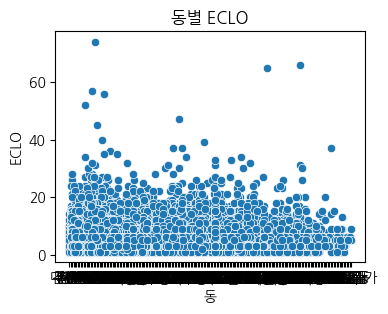

In [ ]:
plt.figure(figsize= (4,3))
sns.scatterplot(x=train_df['동'], y=train_df.ECLO)
plt.title(f'동별 ECLO')

In [ ]:
train_df

ID   요일 기상상태 노면상태  사고유형 사고유형 - 세부분류       법규위반 가해운전자 차종  \
0      ACCIDENT_00000  화요일   맑음   건조  차대사람  길가장자리구역통행중    안전운전불이행       승용   
1      ACCIDENT_00001  화요일   흐림   건조  차대사람       보도통행중         기타       승용   
2      ACCIDENT_00002  화요일   맑음   건조  차대사람       차도통행중    안전운전불이행       승용   
3      ACCIDENT_00003  화요일   맑음   건조   차대차          추돌    안전운전불이행       승용   
4      ACCIDENT_00004  화요일   맑음   건조   차대차          추돌    안전운전불이행       승용   
...               ...  ...  ...  ...   ...         ...        ...      ...   
39604  ACCIDENT_39604  금요일   맑음   건조   차대차        측면충돌       신호위반       승용   
39605  ACCIDENT_39605  금요일   맑음   건조   차대차        측면충돌    안전거리미확보       승용   
39606  ACCIDENT_39606  금요일   맑음   건조   차대차        측면충돌  교차로운행방법위반       승용   
39607  ACCIDENT_39607  금요일   맑음   건조   차대차          추돌    안전운전불이행       승용   
39608  ACCIDENT_39608  금요일   맑음   건조   차대차        측면충돌    안전운전불이행       승용   

      가해운전자 성별 가해운전자 연령  ... ECLO     연   월   일  시간     도시    구      동  도로형태1  \
0            여      51세  ...    5  2019   1   1   0  대구광역시   중구    대신동    단일로   
1            남      39세  ...    3  2019   1   1   0  대구광역시  달서구    감삼동    단일로   
2            남      70세  ...    3  2019   1   1   1  대구광역시  수성구    두산동    단일로   
3            남      49세  ...    5  2019   1   1   2  대구광역시   북구    복현동    단일로   
4            남      30세  ...    3  2019   1   1   4  대구광역시   동구    신암동    단일로   
...        ...      ...  ...  ...   ...  ..  ..  ..    ...  ...    ...    ...   
39604        여      52세  ...    3  2021  12  31  19  대구광역시  수성구  수성동3가    교차로   
39605        여      60세  ...    3  2021  12  31  19  대구광역시  달서구    상인동    단일로   
39606        남      60세  ...   10  2021  12  31  21  대구광역시  달서구    월성동    교차로   
39607        남      40세  ...    3  2021  12  31  22  대구광역시  달서구     장동     기타   
39608        남      27세  ...    6  2021  12  31  23  대구광역시   서구    비산동    단일로   

           도로형태2  
0             기타  
1             기타  
2             기타  
3             기타  
4             기타  
...          ...  
39604       교차로안  
39605         기타  
39606       교차로안  
39607         기타  
39608  지하차도(도로)내  

[39609 rows x 29 columns]

  0%|          | 0/28 [00:00<?, ?it/s]

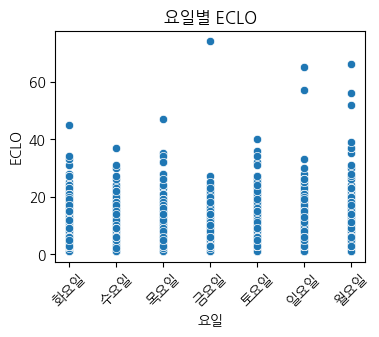

  4%|▎         | 1/28 [00:00<00:07,  3.71it/s]

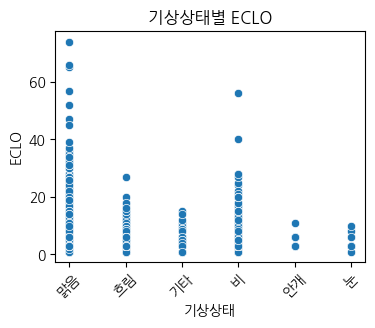

  7%|▋         | 2/28 [00:00<00:07,  3.68it/s]

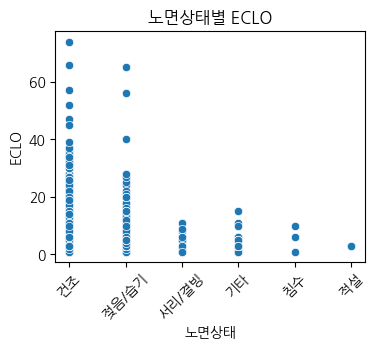

 11%|█         | 3/28 [00:00<00:06,  3.70it/s]

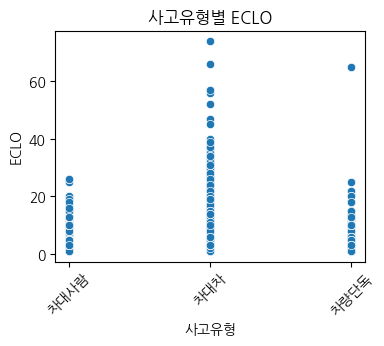

 14%|█▍        | 4/28 [00:01<00:06,  3.73it/s]

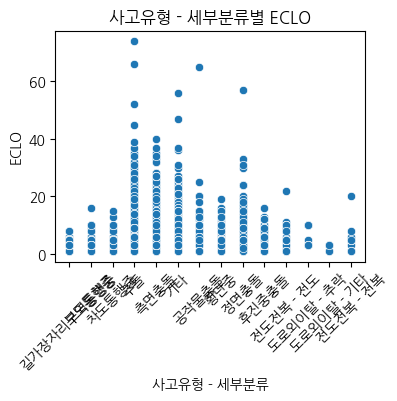

 18%|█▊        | 5/28 [00:01<00:06,  3.50it/s]

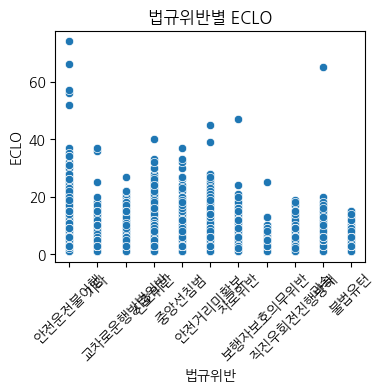

 21%|██▏       | 6/28 [00:01<00:06,  3.40it/s]

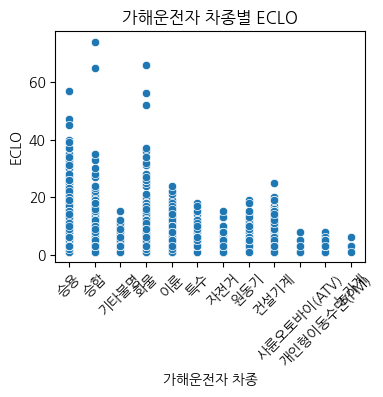

 25%|██▌       | 7/28 [00:02<00:06,  3.36it/s]

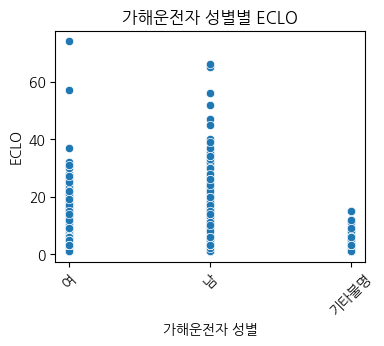

 29%|██▊       | 8/28 [00:02<00:05,  3.51it/s]

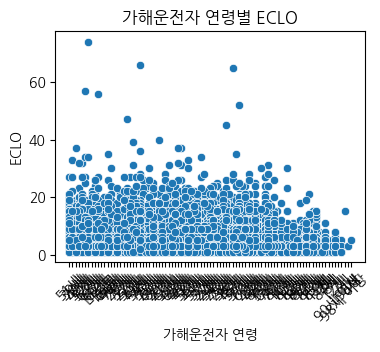

 32%|███▏      | 9/28 [00:02<00:07,  2.44it/s]

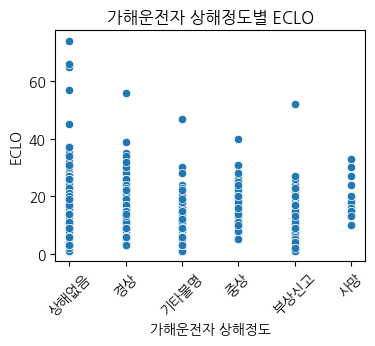

 36%|███▌      | 10/28 [00:03<00:07,  2.40it/s]

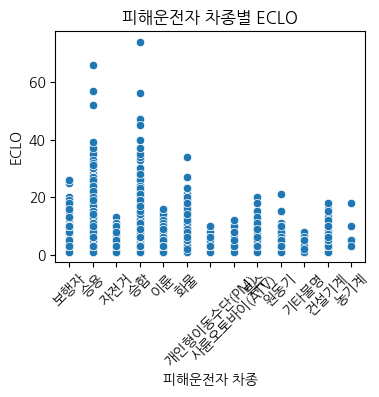

 39%|███▉      | 11/28 [00:03<00:07,  2.27it/s]

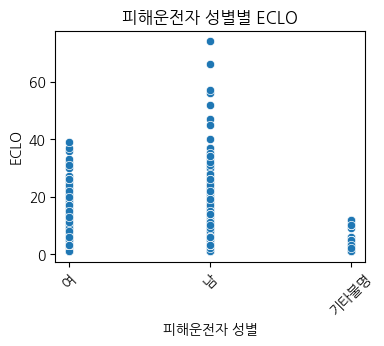

 43%|████▎     | 12/28 [00:04<00:06,  2.32it/s]

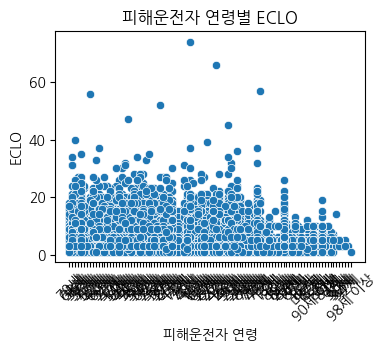

 46%|████▋     | 13/28 [00:05<00:08,  1.70it/s]

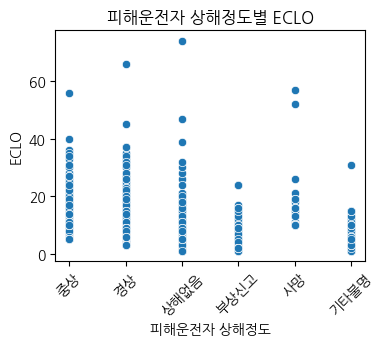

 50%|█████     | 14/28 [00:05<00:07,  1.85it/s]

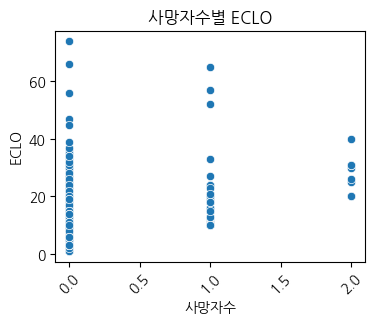

 54%|█████▎    | 15/28 [00:06<00:06,  2.04it/s]

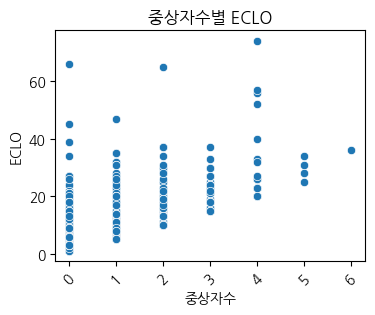

 57%|█████▋    | 16/28 [00:06<00:05,  2.25it/s]

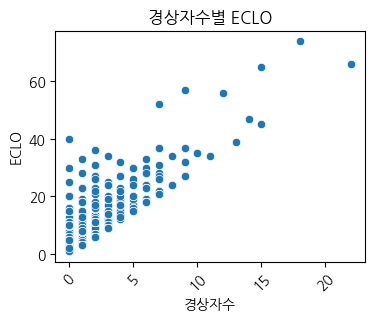

 61%|██████    | 17/28 [00:06<00:04,  2.33it/s]

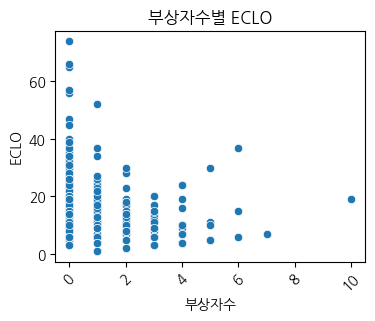

 64%|██████▍   | 18/28 [00:07<00:04,  2.39it/s]

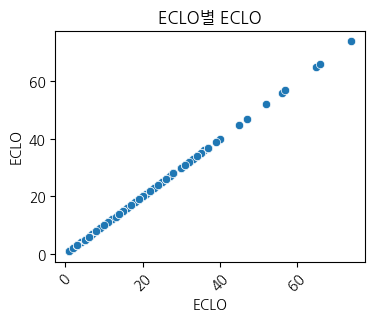

 68%|██████▊   | 19/28 [00:07<00:03,  2.47it/s]

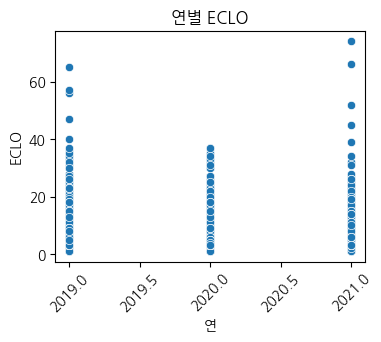

 71%|███████▏  | 20/28 [00:08<00:03,  2.15it/s]

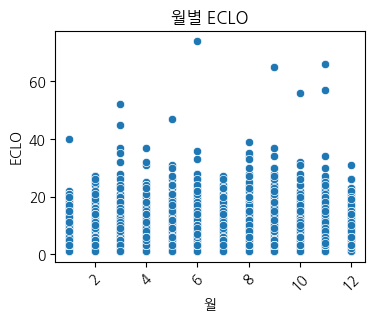

 75%|███████▌  | 21/28 [00:09<00:05,  1.21it/s]

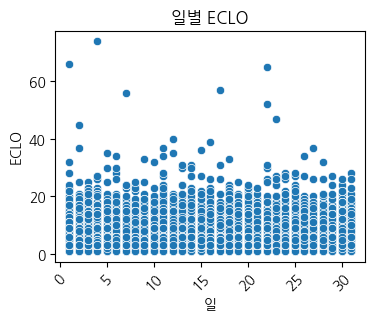

 79%|███████▊  | 22/28 [00:10<00:04,  1.34it/s]

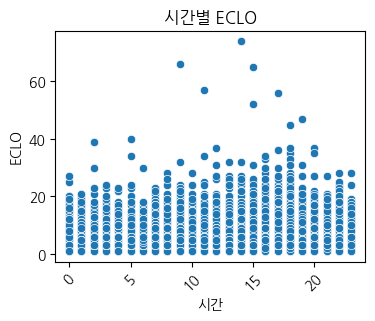

 82%|████████▏ | 23/28 [00:10<00:03,  1.55it/s]

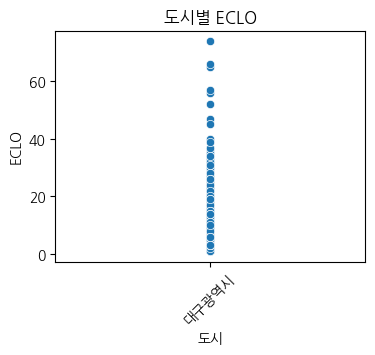

 86%|████████▌ | 24/28 [00:11<00:02,  1.71it/s]

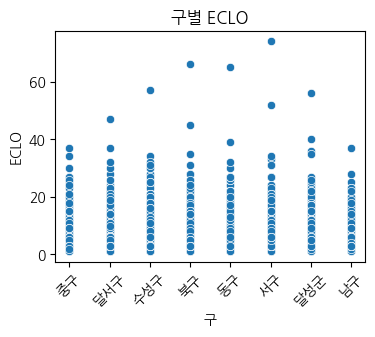

 89%|████████▉ | 25/28 [00:11<00:01,  1.67it/s]

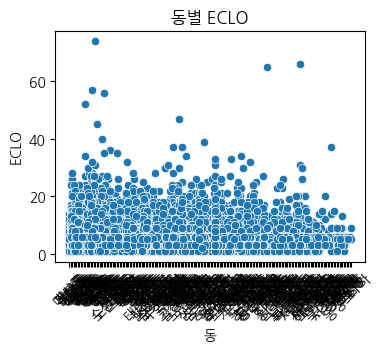

 93%|█████████▎| 26/28 [00:14<00:02,  1.19s/it]

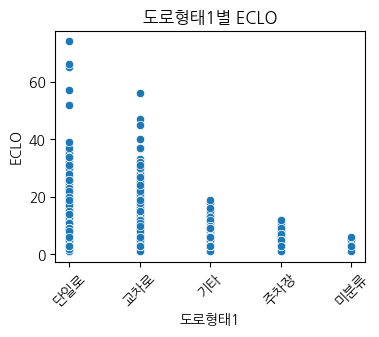

 96%|█████████▋| 27/28 [00:14<00:00,  1.00it/s]

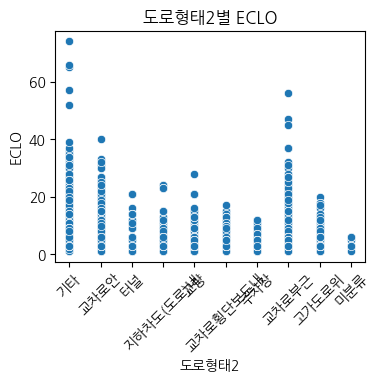

100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


In [ ]:
from tqdm import tqdm

for col in tqdm(train_df.iloc[:,1:].columns) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

## 보안등

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_seculight[['도시', '구', '동','번지']] = DG_seculight['소재지지번주소'].str.extract(location_pattern)
DG_seculight = DG_seculight.drop(columns=['소재지지번주소'])

DG_seculight

보안등위치명  설치개수               소재지도로명주소         위도          경도  \
0              대명1동1     1       대구광역시 남구 현충로 155  35.846703  128.579803   
1              대명1동2     1   대구광역시 남구 현충로31길 10-1  35.846863  128.579406   
2              대명1동3     1    대구광역시 남구 현충로31길 9-8  35.846341  128.579342   
3              대명1동4     2  대구광역시 남구 현충로31길 19-11  35.846368  128.578922   
4              대명1동5     1   대구광역시 남구 현충로29길 22-2  35.845995  128.578858   
...              ...   ...                    ...        ...         ...   
71908     대봉2동 165-9     1                    NaN  35.857556  128.600023   
71909     대봉2동 88-85     1                    NaN  35.859205  128.600046   
71910    대봉2동 719-20     1                    NaN  35.859442  128.599627   
71911    대봉2동 738-13     1                    NaN  35.858244  128.597614   
71912  대봉2동 590-130대     1                    NaN  35.856805  128.596950   

         설치연도 설치형태     도시   구    동       번지  
0      2016.0  한전주  대구광역시  남구  대명동   1722-4  
1      2016.0  한전주  대구광역시  남구  대명동  1723-11  
2      2017.0  건축물  대구광역시  남구  대명동  1722-56  
3      2016.0  한전주  대구광역시  남구  대명동  1722-41  
4      2016.0  한전주  대구광역시  남구  대명동  1721-22  
...       ...  ...    ...  ..  ...      ...  
71908     NaN  한전주  대구광역시  중구  대봉동    165-9  
71909     NaN  한전주  대구광역시  중구  대봉동    88-85  
71910     NaN  한전주  대구광역시  중구  대봉동   719-20  
71911  2010.0  건축물  대구광역시  중구  대봉동   738-13  
71912  2016.0  한전주  대구광역시  중구  대봉동  590-130  

[71913 rows x 11 columns]

In [ ]:
df1 = DG_seculight.groupby(['도시','구','동'])[['설치개수']].sum().reset_index()
df1.columns = ['도시','구','동','보안등_설치개수']

In [ ]:
DG_seculight['설치형태'].value_counts()

한전주    26466
건축물     7316
전용주     1591
Name: 설치형태, dtype: int64

In [ ]:
df2 = pd.get_dummies(DG_seculight['설치형태'], prefix='보안등')
df2 = pd.concat([DG_seculight[['도시','구','동']], df2], axis=1)
df2 = df2.groupby(['도시','구','동']).sum().reset_index().drop(columns =['도시','구','동'])

seculight_merge = pd.concat([df1, df2], axis=1)

train_df = pd.merge(train_df,seculight_merge, on = ['도시','구','동'], how='left')
test_df = pd.merge(test_df,seculight_merge, on = ['도시','구','동'], how='left')

display(seculight_merge.head(3))
display(train_df.head(3))
display(test_df.head(3))

도시   구    동  보안등_설치개수  보안등_건축물  보안등_전용주  보안등_한전주
0  대구광역시  남구  대명동      5377     1647       20     3583
1  대구광역시  남구  봉덕동      1424      394       22      974
2  대구광역시  남구  이천동       556      192       13      346

ID   요일 기상상태 노면상태  사고유형 사고유형 - 세부분류     법규위반 가해운전자 차종 가해운전자 성별  \
0  ACCIDENT_00000  화요일   맑음   건조  차대사람  길가장자리구역통행중  안전운전불이행       승용        여   
1  ACCIDENT_00001  화요일   흐림   건조  차대사람       보도통행중       기타       승용        남   
2  ACCIDENT_00002  화요일   맑음   건조  차대사람       차도통행중  안전운전불이행       승용        남   

  가해운전자 연령  ... 시간     도시    구    동 도로형태1  도로형태2  보안등_설치개수  보안등_건축물  보안등_전용주  \
0      51세  ...  0  대구광역시   중구  대신동   단일로     기타     391.0    177.0     30.0   
1      39세  ...  0  대구광역시  달서구  감삼동   단일로     기타     932.0      0.0      0.0   
2      70세  ...  1  대구광역시  수성구  두산동   단일로     기타     473.0     14.0     31.0   

   보안등_한전주  
0    135.0  
1      0.0  
2    425.0  

[3 rows x 33 columns]

ID   요일 기상상태 노면상태  사고유형     연  월  일  시간     도시    구      동  \
0  ACCIDENT_39609  토요일   맑음   건조  차대사람  2022  1  1   1  대구광역시  수성구     상동   
1  ACCIDENT_39610  토요일   맑음   건조  차대사람  2022  1  1   1  대구광역시  수성구    지산동   
2  ACCIDENT_39611  토요일   맑음   건조   차대차  2022  1  1   4  대구광역시  수성구  수성동2가   

  도로형태1 도로형태2  보안등_설치개수  보안등_건축물  보안등_전용주  보안등_한전주  
0   교차로  교차로안     700.0    104.0     16.0    579.0  
1   단일로    기타       NaN      NaN      NaN      NaN  
2   교차로  교차로안       NaN      NaN      NaN      NaN

In [ ]:
train_df.shape, test_df.shape

((39609, 33), (10963, 18))

  0%|          | 0/4 [00:00<?, ?it/s]

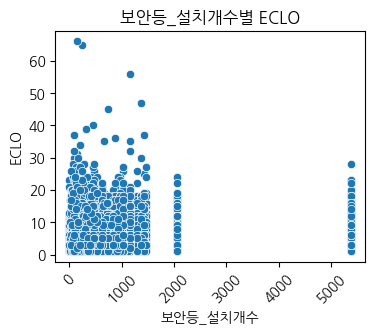

 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

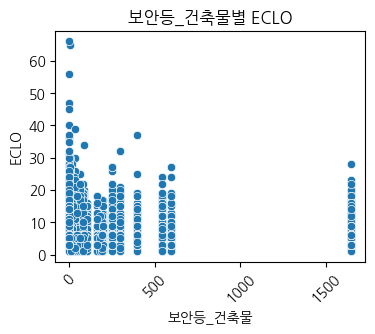

 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

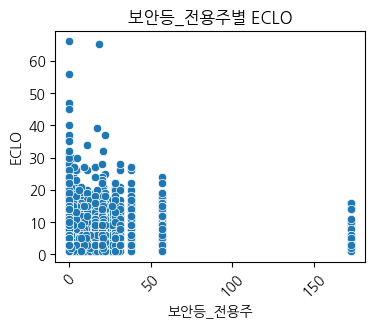

 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

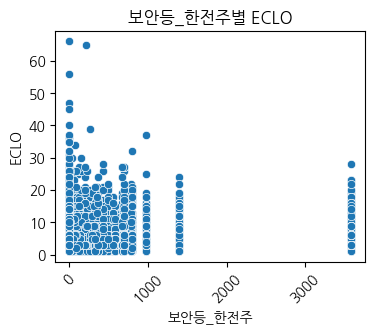

100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


In [ ]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-4:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

## cctv

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_cctv[['도시', '구', '동','번지']] = DG_cctv['소재지지번주소'].str.extract(location_pattern)
DG_cctv = DG_cctv.drop(columns=['소재지지번주소'])



In [ ]:
DG_cctv['cctv_설치개수'] = 1

In [ ]:
train_df['동'].value_counts() # 사고 횟수

대명동      1749
범어동      1173
상인동      1143
비산동       968
내당동       938
         ... 
완전동         2
신용동         2
동성로1가       2
도남동         2
평광동         1
Name: 동, Length: 196, dtype: int64

In [ ]:
# 동별 최빈값으로 cctv 처리  -> one hot이 효과더 좋음

# df = DG_cctv[['도시','구','동']]
# df1 = DG_cctv.groupby(['도시', '구', '동'])[['보호구역구분']].apply(lambda x: x.mode()).reset_index()[['보호구역구분']]
# df2 = DG_cctv.groupby(['도시', '구', '동'])[['단속구분']].apply(lambda x: x.mode()).reset_index()[['단속구분']]
# df3 = DG_cctv.groupby(['도시', '구', '동'])[['도로종류']].apply(lambda x: x.mode()).reset_index()[['도로종류']]
# df4 = DG_cctv.groupby(['도시', '구', '동'])[['제한속도']].apply(lambda x: x.mode()).reset_index()[['제한속도']]

# cctv_merge= pd.concat([df, df1, df2, df3, df4], axis=1)
# cctv_merge #23개 열

# train_df = train_df.merge(cctv_merge, on = ['도시','구','동'], how='left')
# test_df = test_df.merge(cctv_merge, on = ['도시','구','동'], how='left')

In [ ]:
DG_cctv

무인교통단속카메라관리번호    시도명 시군구명  도로종류 도로노선번호  도로노선명  도로노선방향  \
0             주차12  대구광역시   남구    시도    NaN    대명로       3   
1             주차13  대구광역시   남구    시도    NaN    봉덕로       3   
2             주차14  대구광역시   남구    시도    NaN    대봉로       3   
3             주차15  대구광역시   남구    시도    NaN    큰골길       3   
4             주차16  대구광역시   남구    시도    NaN    큰골길       3   
...            ...    ...  ...   ...    ...    ...     ...   
1060         H2418  대구광역시   북구  특별시도    NaN   태암남로       1   
1061         H2419  대구광역시   북구  특별시도    NaN    내곡로       1   
1062         H4145  대구광역시   북구  특별시도    NaN    대현로       2   
1063         H4146  대구광역시   북구  특별시도    NaN    대현로       1   
1064         H6953  대구광역시  달서구  특별시도      5  두류공원로       1   

                 소재지도로명주소         위도          경도  ... 제한속도  단속구간위치구분  \
0        대구광역시 남구 대명로 162  35.838857  128.575418  ...    0       NaN   
1        대구광역시 남구 봉덕로 135  35.844653  128.604619  ...    0       NaN   
2        대구광역시 남구 봉덕로 134  35.844183  128.604815  ...    0       NaN   
3        대구광역시 남구 큰골길 200  35.834798  128.585284  ...    0       NaN   
4        대구광역시 남구 큰골길 243  35.832728  128.588324  ...    0       NaN   
...                   ...        ...         ...  ...  ...       ...   
1060     대구광역시 북구 태암남로 41  35.925294  128.552023  ...   40       NaN   
1061      대구광역시 북구 내곡로 90  35.900977  128.513825  ...   30       NaN   
1062     대구광역시 북구 대현로 100  35.882191  128.609791  ...   30       NaN   
1063     대구광역시 북구 대현로 118  35.881737  128.611651  ...   30       NaN   
1064  대구광역시 달서구 두류공원로 242  35.855327  128.559830  ...   50       NaN   

      과속단속구간길이  보호구역구분    설치연도     도시    구    동       번지 cctv_설치개수  
0          NaN    99.0  2010.0  대구광역시   남구  대명동   903-13         1  
1          NaN    99.0  2013.0  대구광역시   남구  봉덕동    853-8         1  
2          NaN    99.0  2013.0  대구광역시   남구  봉덕동   866-46         1  
3          NaN    99.0  2014.0  대구광역시   남구  대명동  2680-17         1  
4          NaN    99.0  2014.0  대구광역시   남구  봉덕동     1616         1  
...        ...     ...     ...    ...  ...  ...      ...       ...  
1060       NaN    99.0  2021.0  대구광역시   북구  구암동    671-8         1  
1061       NaN     2.0  2021.0  대구광역시   북구  사수동      812         1  
1062       NaN     2.0  2021.0  대구광역시   북구  대현동    270-8         1  
1063       NaN     2.0  2021.0  대구광역시   북구  대현동    270-3         1  
1064       NaN    99.0  2021.0  대구광역시  달서구  두류동    147-7         1  

[1065 rows x 22 columns]

In [ ]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_cctv[['도시','구','동']]
df['cctv_설치개수'] = 1

df1 = pd.get_dummies(DG_cctv['보호구역구분'], prefix = '보호구역구분')
df2 = pd.get_dummies(DG_cctv['단속구분'], prefix = '단속구분')
df3 = pd.get_dummies(DG_cctv['도로종류'], prefix = '도로종류')
df4 = pd.get_dummies(DG_cctv['제한속도'], prefix = '제한속도')

cctv_merge= pd.concat([df, df1, df2, df3, df4], axis=1) #23개 열

cctv_merge_df = cctv_merge.groupby(['도시','구','동']).sum().reset_index()
display(cctv_merge_df)

train_df = train_df.merge(cctv_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(cctv_merge_df, on = ['도시','구','동'], how='left')

<ipython-input-42-675e7ed6634d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cctv_설치개수'] = 1


도시    구      동  cctv_설치개수  보호구역구분_1.0  보호구역구분_2.0  보호구역구분_99.0  \
0       대구  달성군    가창면          2           0           1            0   
1       대구  달성군    구지면          1           0           1            0   
2       대구  달성군    다사읍          8           0           5            0   
3       대구  달성군    옥포읍          6           0           5            0   
4       대구  달성군    유가읍          3           0           2            0   
..     ...  ...    ...        ...         ...         ...          ...   
176  대구광역시   중구    인교동          2           0           1            0   
177  대구광역시   중구   종로1가          2           0           0            1   
178  대구광역시   중구   종로2가          1           0           1            0   
179  대구광역시   중구  태평로1가          1           0           0            0   
180  대구광역시   중구  태평로3가          1           0           0            1   

     단속구분_1  단속구분_2  단속구분_4  ...  도로종류_특별시도  제한속도_0  제한속도_30  제한속도_40  \
0         2       0       0  ...          0       0        1        0   
1         1       0       0  ...          0       0        1        0   
2         2       6       0  ...          0       0        6        0   
3         3       2       0  ...          0       0        4        0   
4         0       2       0  ...          0       0        2        0   
..      ...     ...     ...  ...        ...     ...      ...      ...   
176       0       1       1  ...          1       1        0        1   
177       0       1       1  ...          1       1        0        0   
178       0       0       1  ...          0       1        0        0   
179       0       0       1  ...          0       1        0        0   
180       0       1       0  ...          1       0        0        0   

     제한속도_50  제한속도_60  제한속도_70  제한속도_80  제한속도_100  제한속도_110  
0          0        1        0        0         0         0  
1          0        0        0        0         0         0  
2          0        2        0        0         0         0  
3          1        0        0        1         0         0  
4          0        0        0        1         0         0  
..       ...      ...      ...      ...       ...       ...  
176        0        0        0        0         0         0  
177        1        0        0        0         0         0  
178        0        0        0        0         0         0  
179        0        0        0        0         0         0  
180        1        0        0        0         0         0  

[181 rows x 27 columns]

In [ ]:
train_df.shape, test_df.shape

((39609, 57), (10963, 42))

In [ ]:
train_df.columns[-24:]

Index(['cctv_설치개수', '보호구역구분_1.0', '보호구역구분_2.0', '보호구역구분_99.0', '단속구분_1',
       '단속구분_2', '단속구분_4', '단속구분_99', '도로종류_고속국도', '도로종류_구도', '도로종류_군도',
       '도로종류_시도', '도로종류_일반국도', '도로종류_지방도', '도로종류_특별시도', '제한속도_0', '제한속도_30',
       '제한속도_40', '제한속도_50', '제한속도_60', '제한속도_70', '제한속도_80', '제한속도_100',
       '제한속도_110'],
      dtype='object')

  0%|          | 0/24 [00:00<?, ?it/s]

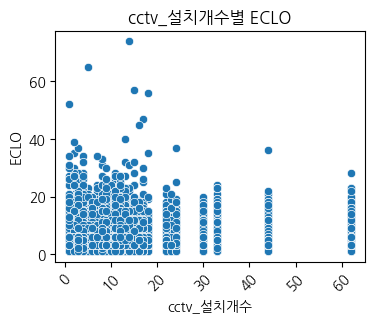

  4%|▍         | 1/24 [00:00<00:06,  3.37it/s]

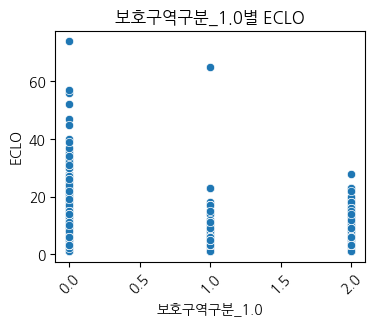

  8%|▊         | 2/24 [00:00<00:06,  3.43it/s]

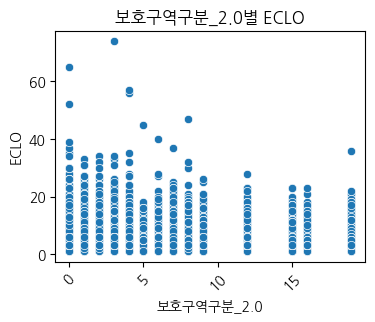

 12%|█▎        | 3/24 [00:00<00:05,  3.53it/s]

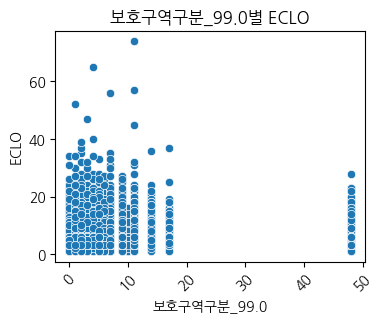

 17%|█▋        | 4/24 [00:01<00:05,  3.58it/s]

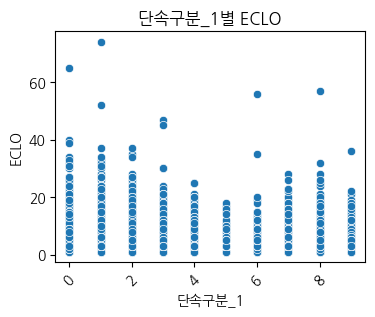

 21%|██        | 5/24 [00:01<00:05,  3.65it/s]

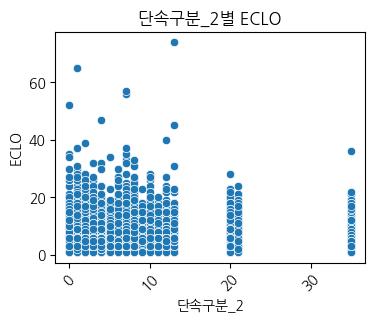

 25%|██▌       | 6/24 [00:01<00:05,  3.55it/s]

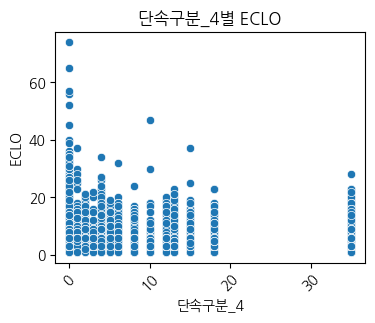

 29%|██▉       | 7/24 [00:02<00:05,  3.20it/s]

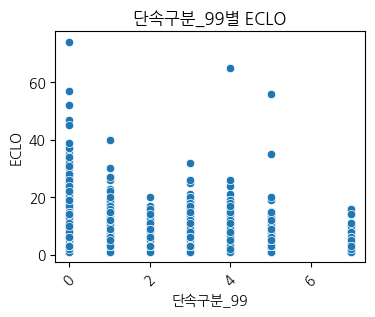

 33%|███▎      | 8/24 [00:02<00:05,  2.98it/s]

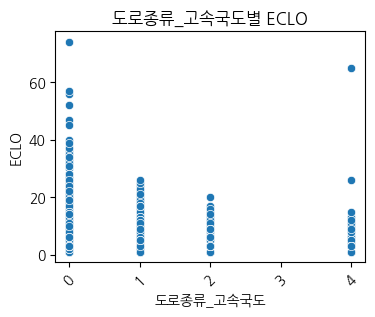

 38%|███▊      | 9/24 [00:02<00:05,  2.98it/s]

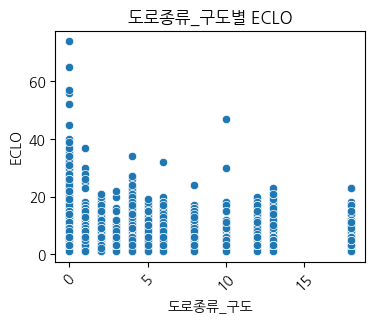

 42%|████▏     | 10/24 [00:03<00:04,  2.84it/s]

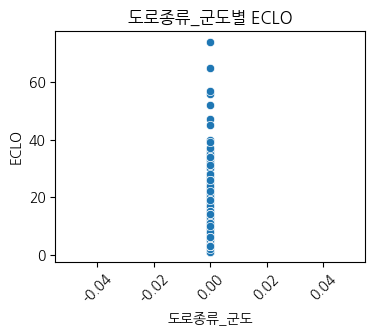

 46%|████▌     | 11/24 [00:03<00:04,  2.75it/s]

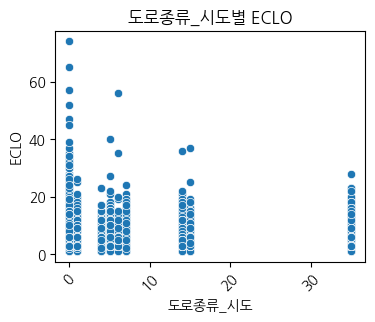

 50%|█████     | 12/24 [00:03<00:04,  2.70it/s]

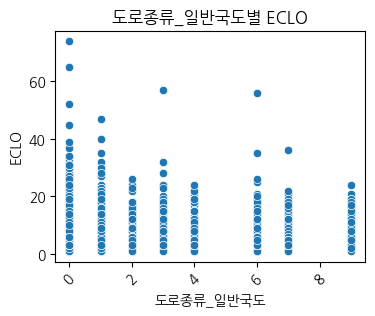

 54%|█████▍    | 13/24 [00:04<00:04,  2.73it/s]

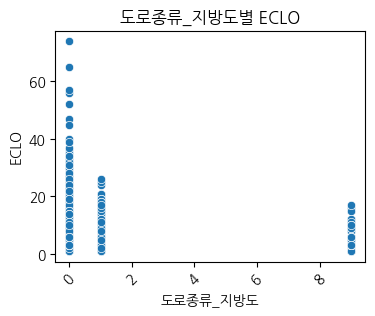

 58%|█████▊    | 14/24 [00:04<00:03,  2.69it/s]

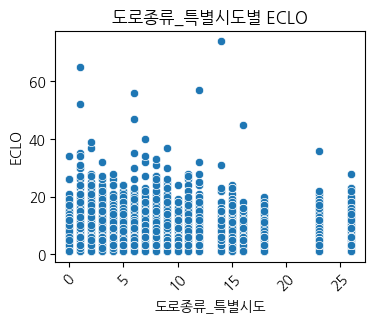

 62%|██████▎   | 15/24 [00:05<00:03,  2.59it/s]

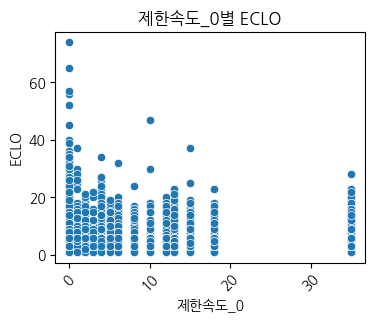

 67%|██████▋   | 16/24 [00:05<00:03,  2.60it/s]

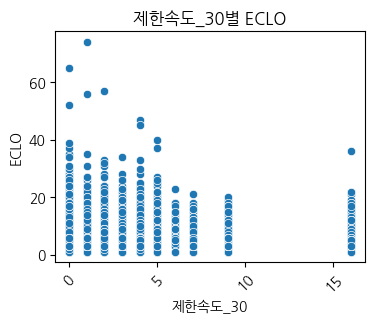

 71%|███████   | 17/24 [00:05<00:02,  2.64it/s]

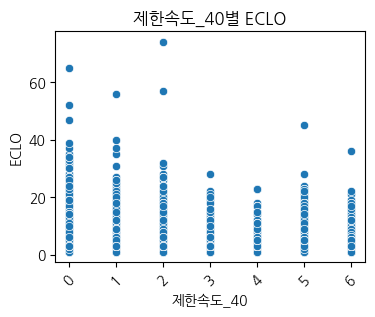

 75%|███████▌  | 18/24 [00:06<00:02,  2.68it/s]

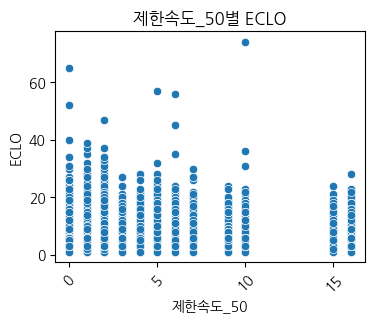

 79%|███████▉  | 19/24 [00:06<00:01,  2.57it/s]

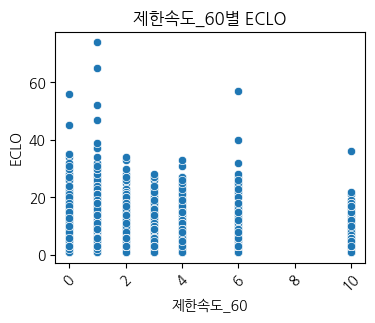

 83%|████████▎ | 20/24 [00:07<00:01,  2.58it/s]

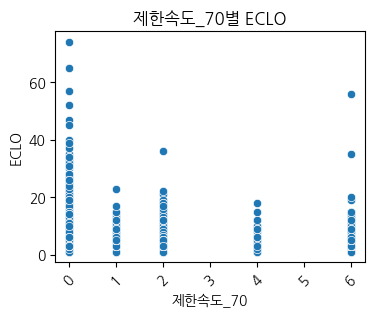

 88%|████████▊ | 21/24 [00:07<00:01,  2.60it/s]

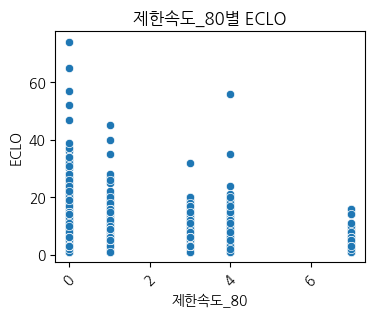

 92%|█████████▏| 22/24 [00:07<00:00,  2.60it/s]

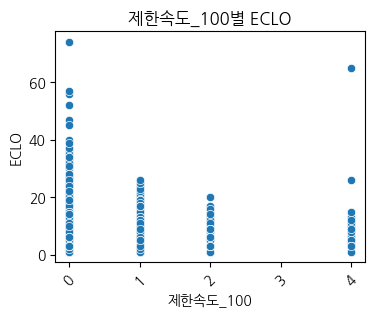

 96%|█████████▌| 23/24 [00:08<00:00,  2.60it/s]

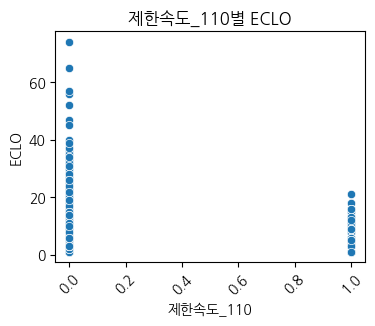

100%|██████████| 24/24 [00:08<00:00,  2.76it/s]


In [ ]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-24:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

# 필수 : 설치 개수, 보호구역 01, 02, 단속구분 04,99, 고속국도별, 구도별, 시도별, 일반국도별, 지방도별, 제한속도 0별, 30, 40, 제한속도 70별, 제한속도 80별, 100별, 110별
# 선택 : 단속구분 99, 일반국도별,

In [ ]:
DG_cctv['제한속도'].value_counts()


50     274
0      232
30     218
60     187
40      80
80      32
70      22
100     19
110      1
Name: 제한속도, dtype: int64

In [ ]:
DG_cctv['보호구역구분'].value_counts()

99.0    522
2.0     366
1.0       5
Name: 보호구역구분, dtype: int64

In [ ]:
DG_cctv['단속구분'].value_counts()

2     575
4     232
1     207
99     51
Name: 단속구분, dtype: int64

In [ ]:
DG_cctv['도로종류'].value_counts()

특별시도    626
구도      178
시도      132
일반국도     81
지방도      27
고속국도     20
군도        1
Name: 도로종류, dtype: int64

## 어린이 보호구역

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_children_area[['도시', '구', '동','번지']] = DG_children_area['소재지지번주소'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['소재지지번주소'])

DG_children_area

시설종류     대상시설명                  소재지도로명주소         위도          경도  \
0    초등학교    남도초등학교     대구광역시 남구 현충동길 74(대명동)  35.845027  128.581402   
1    초등학교    영선초등학교       대구광역시 남구 영선길96(이천동)  35.852901  128.596014   
2    초등학교    성명초등학교  대구광역시 남구 성당로 30길 55(대명동)  35.845152  128.570825   
3    초등학교    남덕초등학교     대구광역시 남구 앞산순환로 93길 33  35.833042  128.573949   
4    초등학교    대명초등학교          대구광역시 남구 대명로 110  35.838869  128.568889   
..    ...       ...                       ...        ...         ...   
635  어린이집  남산교회어린이집          대구광역시 중구 관덕정길 16  35.865040  128.590565   
636  초등학교    대구초등학교        대구광역시 중구 명륜로23길 80  35.864037  128.595370   
637  어린이집  대구삼성어린이집    대구광역시 중구 달구벌대로 2016-40  35.864469  128.584301   
638  어린이집  동화나라어린이집        대구광역시 중구 남산로3안길 20  35.860371  128.577492   
639  어린이집   꿈나무어린이집         대구광역시 중구 남산로7길 35  35.858483  128.580584   

         관리기관명       관할경찰서명 CCTV설치여부  CCTV설치대수 보호구역도로폭     데이터기준일자     도시   구  \
0        대구광역시        남부경찰서        Y       7.0     6~8  2020-03-23  대구광역시  남구   
1        대구광역시        남부경찰서        Y       8.0    6~10  2020-03-23  대구광역시  남구   
2        대구광역시        남부경찰서        Y      14.0    8~12  2020-03-23  대구광역시  남구   
3        대구광역시        남부경찰서        Y       6.0     6~8  2020-03-23  대구광역시  남구   
4        대구광역시        남부경찰서        Y       5.0    6~10  2020-03-23  대구광역시  남구   
..         ...          ...      ...       ...     ...         ...    ...  ..   
635  대구광역시 중구청  대구광역시 중부경찰서        Y       5.0    6~10  2019-06-01  대구광역시  중구   
636  대구광역시 중구청  대구광역시 중부경찰서        Y      12.0    3~12  2019-06-01  대구광역시  중구   
637  대구광역시 중구청  대구광역시 중부경찰서        Y       2.0     7~8  2019-06-01  대구광역시  중구   
638  대구광역시 중구청  대구광역시 중부경찰서        Y       5.0     6~8  2019-06-01  대구광역시  중구   
639  대구광역시 중구청  대구광역시 중부경찰서        Y       4.0    7~11  2019-06-01  대구광역시  중구   

       동      번지  
0    대명동    1709  
1    이천동     477  
2    대명동    3050  
3    대명동   531-1  
4    대명동     960  
..   ...     ...  
635  남산동   941-1  
636  봉산동      57  
637  남산동   153-2  
638  남산동  2623-6  
639  남산동  2508-2  

[640 rows x 15 columns]

In [ ]:
location_pattern = r'(\S+)~(\S+)'

DG_children_area[['보호구역도로폭_min', '보호구역도로폭_max']] = DG_children_area['보호구역도로폭'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['보호구역도로폭'])

DG_children_area

시설종류     대상시설명                  소재지도로명주소         위도          경도  \
0    초등학교    남도초등학교     대구광역시 남구 현충동길 74(대명동)  35.845027  128.581402   
1    초등학교    영선초등학교       대구광역시 남구 영선길96(이천동)  35.852901  128.596014   
2    초등학교    성명초등학교  대구광역시 남구 성당로 30길 55(대명동)  35.845152  128.570825   
3    초등학교    남덕초등학교     대구광역시 남구 앞산순환로 93길 33  35.833042  128.573949   
4    초등학교    대명초등학교          대구광역시 남구 대명로 110  35.838869  128.568889   
..    ...       ...                       ...        ...         ...   
635  어린이집  남산교회어린이집          대구광역시 중구 관덕정길 16  35.865040  128.590565   
636  초등학교    대구초등학교        대구광역시 중구 명륜로23길 80  35.864037  128.595370   
637  어린이집  대구삼성어린이집    대구광역시 중구 달구벌대로 2016-40  35.864469  128.584301   
638  어린이집  동화나라어린이집        대구광역시 중구 남산로3안길 20  35.860371  128.577492   
639  어린이집   꿈나무어린이집         대구광역시 중구 남산로7길 35  35.858483  128.580584   

         관리기관명       관할경찰서명 CCTV설치여부  CCTV설치대수     데이터기준일자     도시   구    동  \
0        대구광역시        남부경찰서        Y       7.0  2020-03-23  대구광역시  남구  대명동   
1        대구광역시        남부경찰서        Y       8.0  2020-03-23  대구광역시  남구  이천동   
2        대구광역시        남부경찰서        Y      14.0  2020-03-23  대구광역시  남구  대명동   
3        대구광역시        남부경찰서        Y       6.0  2020-03-23  대구광역시  남구  대명동   
4        대구광역시        남부경찰서        Y       5.0  2020-03-23  대구광역시  남구  대명동   
..         ...          ...      ...       ...         ...    ...  ..  ...   
635  대구광역시 중구청  대구광역시 중부경찰서        Y       5.0  2019-06-01  대구광역시  중구  남산동   
636  대구광역시 중구청  대구광역시 중부경찰서        Y      12.0  2019-06-01  대구광역시  중구  봉산동   
637  대구광역시 중구청  대구광역시 중부경찰서        Y       2.0  2019-06-01  대구광역시  중구  남산동   
638  대구광역시 중구청  대구광역시 중부경찰서        Y       5.0  2019-06-01  대구광역시  중구  남산동   
639  대구광역시 중구청  대구광역시 중부경찰서        Y       4.0  2019-06-01  대구광역시  중구  남산동   

         번지 보호구역도로폭_min 보호구역도로폭_max  
0      1709           6           8  
1       477           6          10  
2      3050           8          12  
3     531-1           6           8  
4       960           6          10  
..      ...         ...         ...  
635   941-1           6          10  
636      57           3          12  
637   153-2           7           8  
638  2623-6           6           8  
639  2508-2           7          11  

[640 rows x 16 columns]

In [ ]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_children_area[['도시','구','동']]

df1 = pd.get_dummies(DG_children_area['시설종류'], prefix = '시설종류')
df2 = pd.get_dummies(DG_children_area['관할경찰서명'], prefix = '관할경찰서명')
df3 = pd.get_dummies(DG_children_area['관리기관명'], prefix = '관리기관명')
df4 = pd.get_dummies(DG_children_area['CCTV설치대수'], prefix = '보호CCTV설치대수')
df5 = pd.get_dummies(DG_children_area['보호구역도로폭_min'], prefix = '보호구역도로폭_min')
df6 = pd.get_dummies(DG_children_area['보호구역도로폭_max'], prefix = '보호구역도로폭_max')


children_area_merge= pd.concat([df, df1, df2, df3, df4, df5, df6], axis=1)
children_area_merge #23개 열

children_area_merge_df = children_area_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(children_area_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(children_area_merge_df, on = ['도시','구','동'], how='left')

In [ ]:
children_area_merge.shape

(640, 59)

  0%|          | 0/56 [00:00<?, ?it/s]

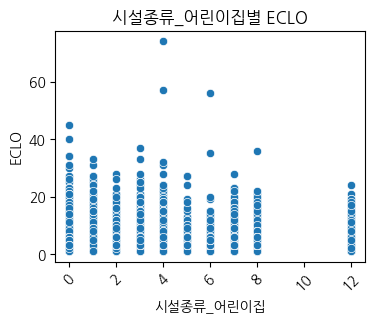

  2%|▏         | 1/56 [00:00<00:13,  4.02it/s]

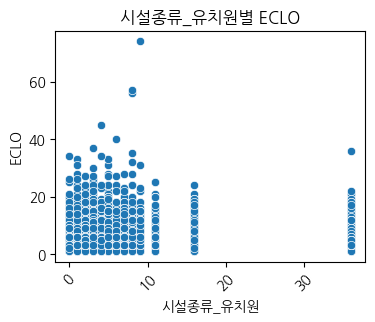

  4%|▎         | 2/56 [00:00<00:13,  4.00it/s]

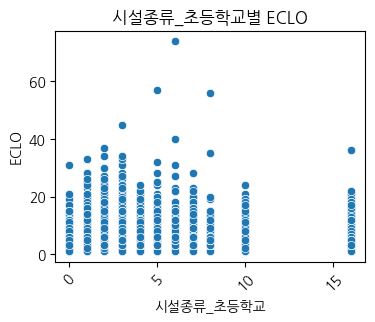

  5%|▌         | 3/56 [00:00<00:13,  4.08it/s]

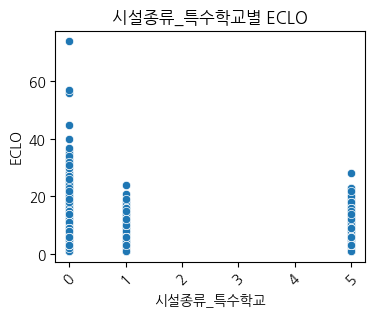

  7%|▋         | 4/56 [00:00<00:12,  4.11it/s]

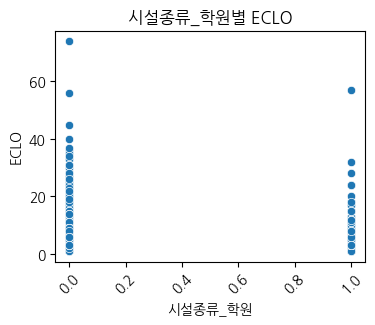

  9%|▉         | 5/56 [00:01<00:12,  4.13it/s]

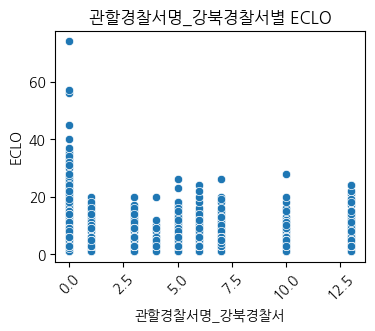

 11%|█         | 6/56 [00:01<00:12,  4.14it/s]

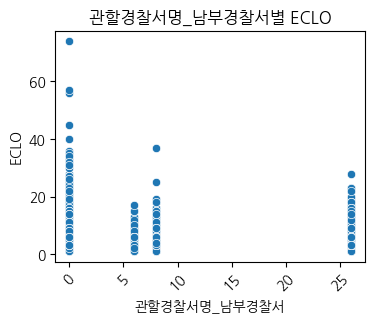

 12%|█▎        | 7/56 [00:01<00:11,  4.13it/s]

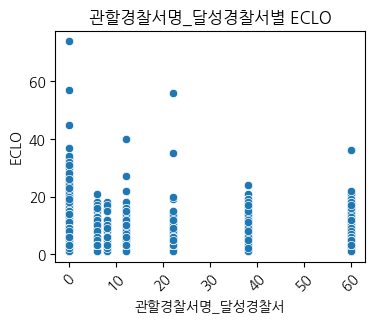

 14%|█▍        | 8/56 [00:01<00:11,  4.13it/s]

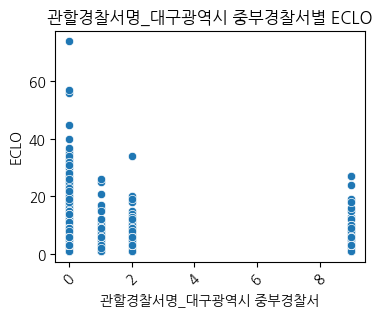

 16%|█▌        | 9/56 [00:02<00:11,  4.15it/s]

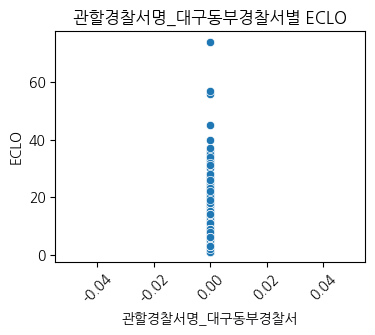

 18%|█▊        | 10/56 [00:02<00:10,  4.19it/s]

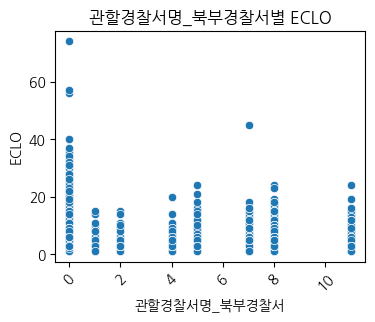

 20%|█▉        | 11/56 [00:02<00:10,  4.17it/s]

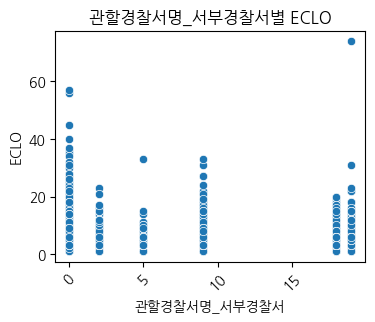

 21%|██▏       | 12/56 [00:02<00:10,  4.23it/s]

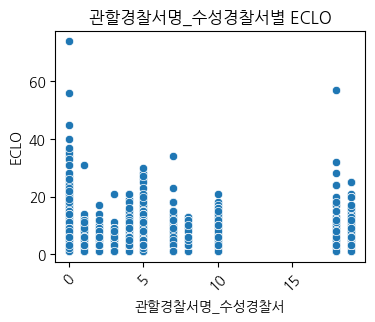

 23%|██▎       | 13/56 [00:03<00:10,  4.23it/s]

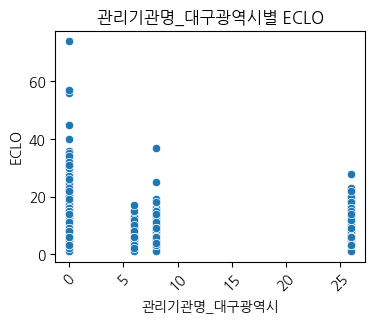

 25%|██▌       | 14/56 [00:03<00:10,  4.16it/s]

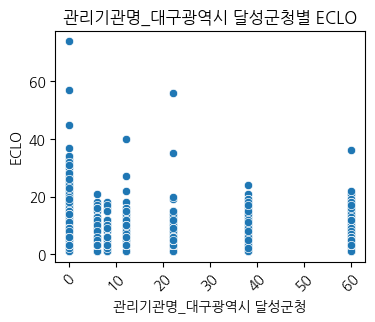

 27%|██▋       | 15/56 [00:03<00:10,  4.10it/s]

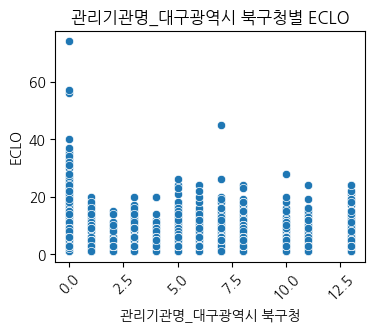

 29%|██▊       | 16/56 [00:03<00:09,  4.12it/s]

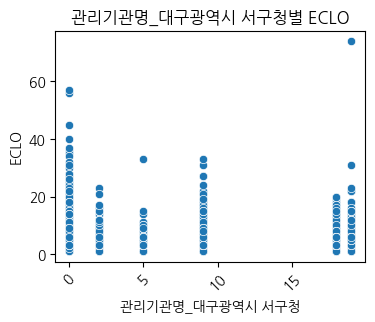

 30%|███       | 17/56 [00:04<00:09,  4.15it/s]

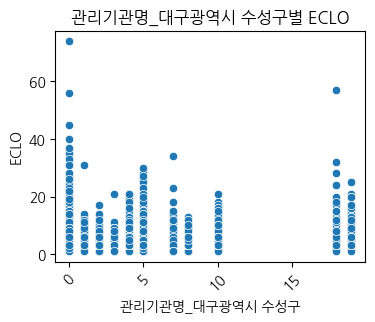

 32%|███▏      | 18/56 [00:04<00:09,  4.19it/s]

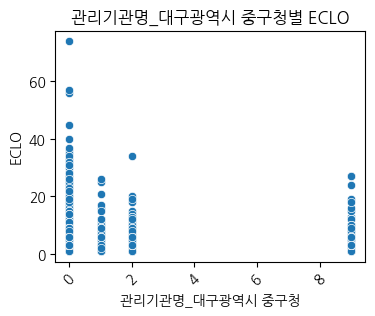

 34%|███▍      | 19/56 [00:04<00:08,  4.14it/s]

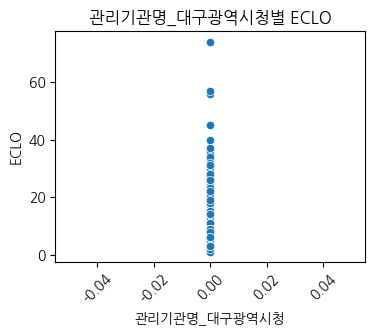

 36%|███▌      | 20/56 [00:04<00:08,  4.19it/s]

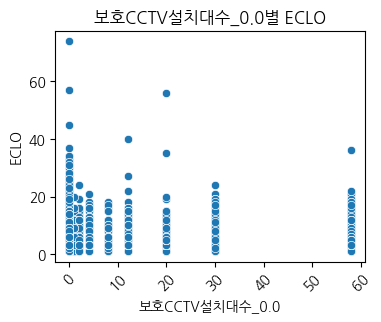

 38%|███▊      | 21/56 [00:05<00:08,  4.23it/s]

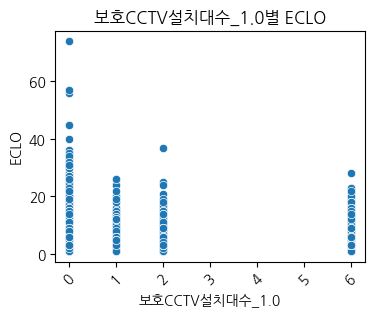

 39%|███▉      | 22/56 [00:05<00:08,  4.24it/s]

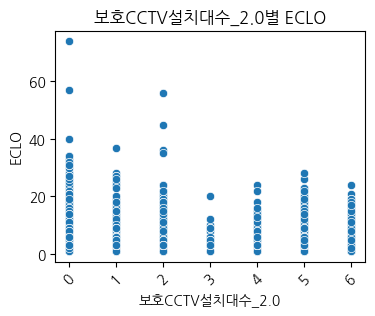

 41%|████      | 23/56 [00:05<00:07,  4.22it/s]

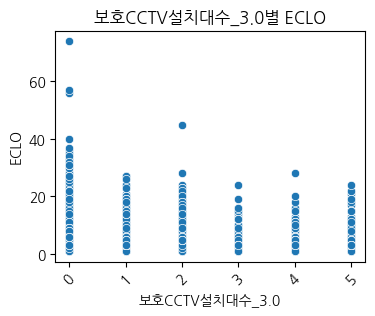

 43%|████▎     | 24/56 [00:05<00:07,  4.18it/s]

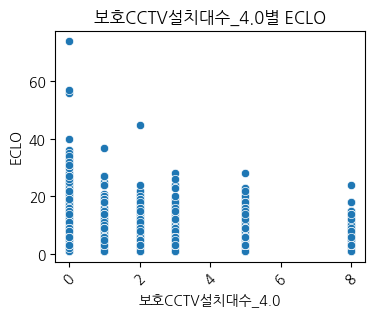

 45%|████▍     | 25/56 [00:06<00:07,  4.17it/s]

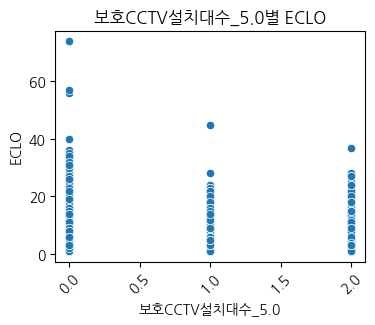

 46%|████▋     | 26/56 [00:06<00:07,  4.21it/s]

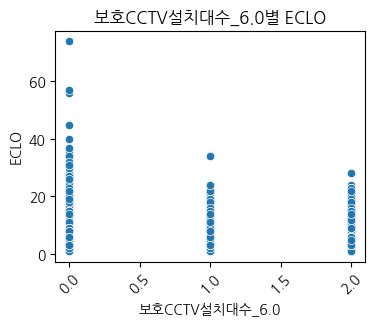

 48%|████▊     | 27/56 [00:06<00:06,  4.21it/s]

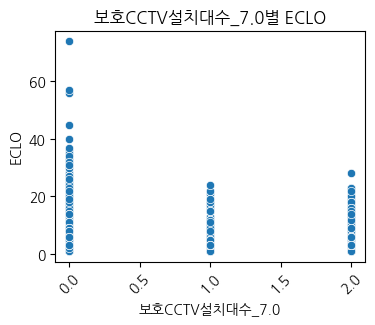

 50%|█████     | 28/56 [00:06<00:06,  4.18it/s]

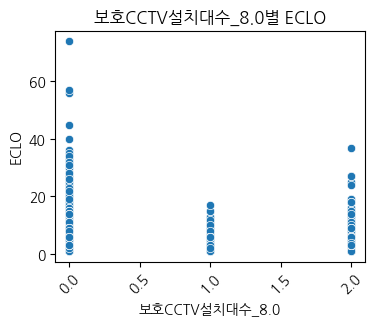

 52%|█████▏    | 29/56 [00:07<00:07,  3.38it/s]

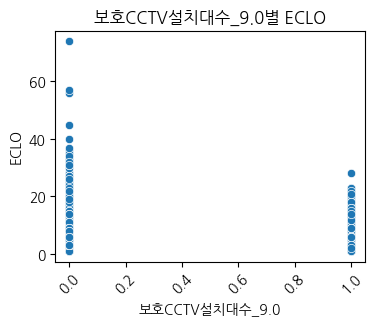

 54%|█████▎    | 30/56 [00:07<00:07,  3.54it/s]

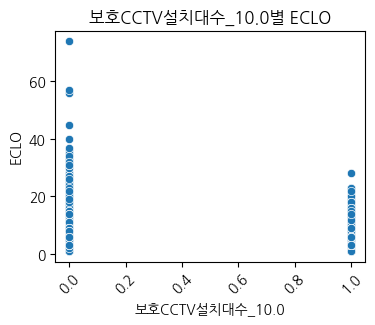

 55%|█████▌    | 31/56 [00:07<00:06,  3.73it/s]

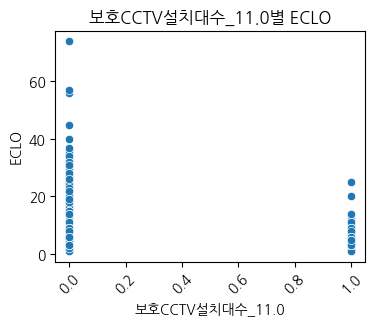

 57%|█████▋    | 32/56 [00:07<00:06,  3.79it/s]

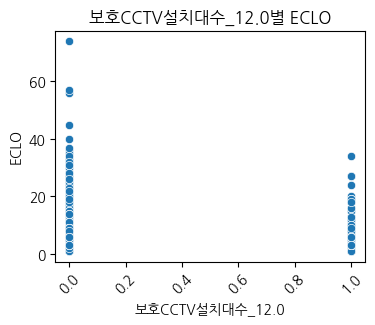

 59%|█████▉    | 33/56 [00:08<00:05,  3.90it/s]

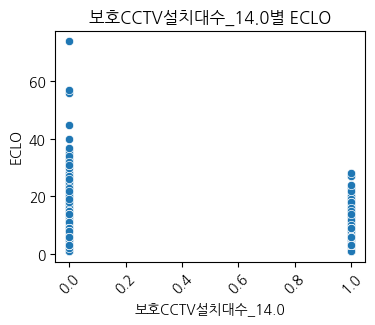

 61%|██████    | 34/56 [00:08<00:05,  3.93it/s]

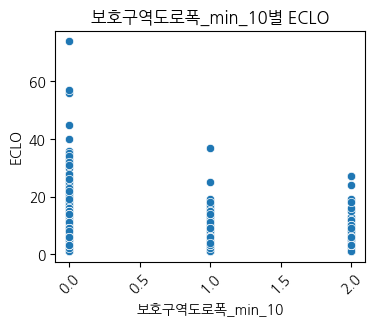

 62%|██████▎   | 35/56 [00:08<00:05,  3.97it/s]

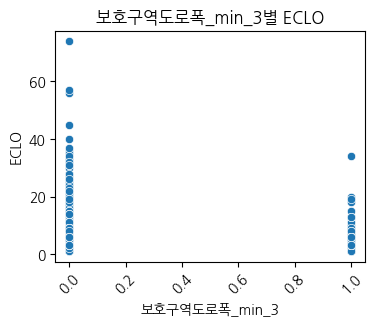

 64%|██████▍   | 36/56 [00:08<00:05,  3.97it/s]

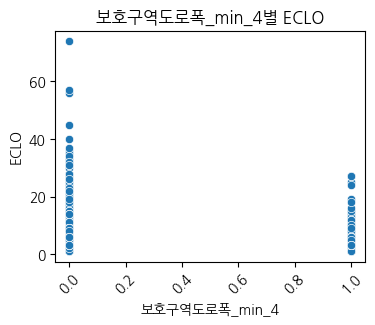

 66%|██████▌   | 37/56 [00:09<00:04,  4.01it/s]

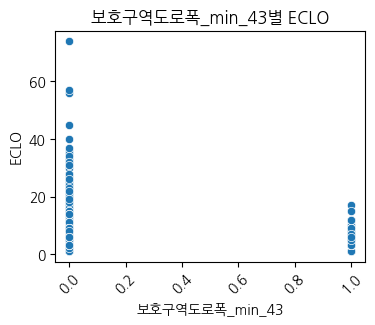

 68%|██████▊   | 38/56 [00:09<00:04,  4.03it/s]

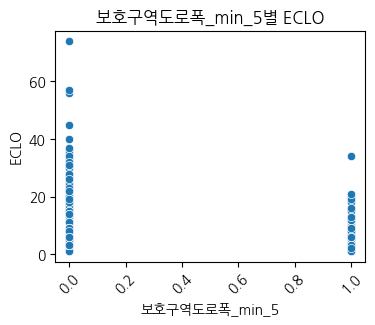

 70%|██████▉   | 39/56 [00:09<00:04,  3.80it/s]

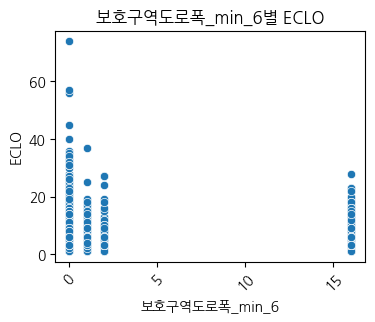

 71%|███████▏  | 40/56 [00:09<00:04,  3.54it/s]

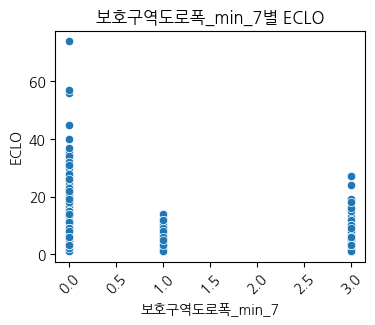

 73%|███████▎  | 41/56 [00:10<00:04,  3.46it/s]

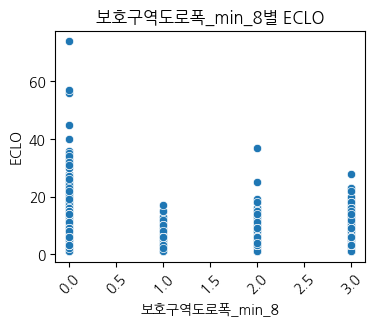

 75%|███████▌  | 42/56 [00:10<00:04,  3.19it/s]

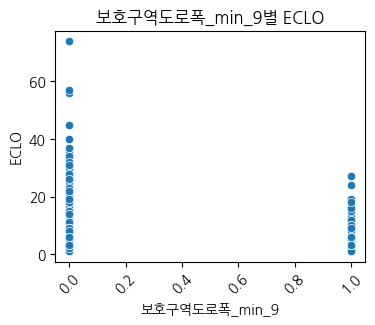

 77%|███████▋  | 43/56 [00:10<00:04,  3.15it/s]

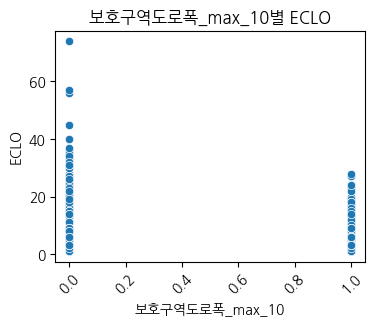

 79%|███████▊  | 44/56 [00:11<00:03,  3.10it/s]

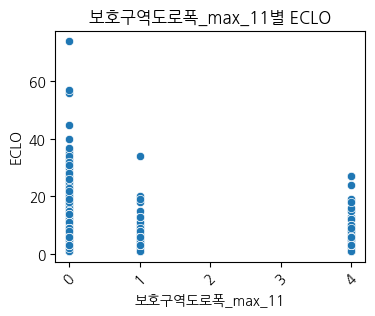

 80%|████████  | 45/56 [00:11<00:03,  3.10it/s]

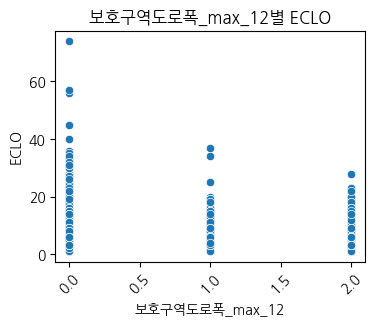

 82%|████████▏ | 46/56 [00:11<00:03,  3.03it/s]

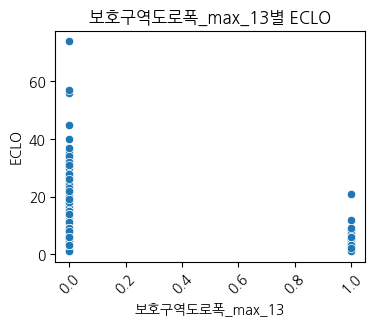

 84%|████████▍ | 47/56 [00:12<00:03,  2.96it/s]

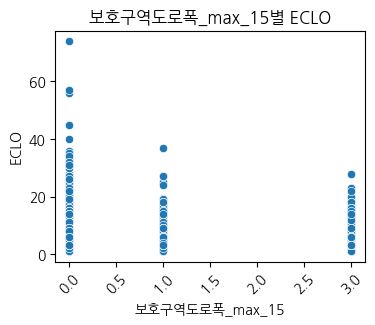

 86%|████████▌ | 48/56 [00:12<00:02,  2.96it/s]

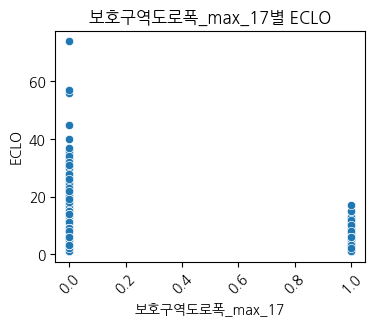

 88%|████████▊ | 49/56 [00:13<00:02,  2.88it/s]

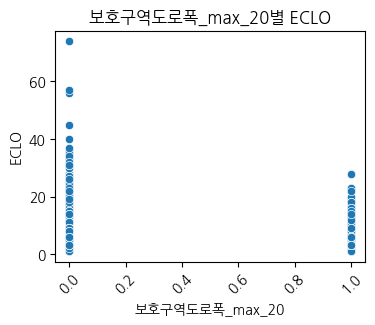

 89%|████████▉ | 50/56 [00:13<00:02,  2.80it/s]

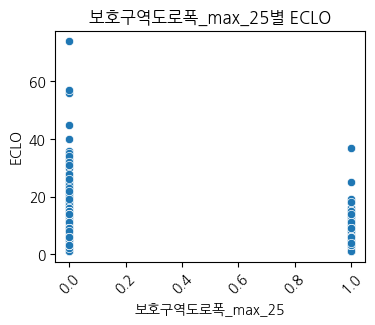

 91%|█████████ | 51/56 [00:13<00:01,  2.76it/s]

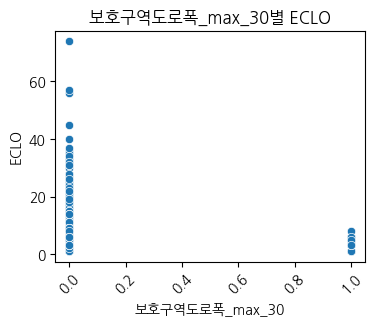

 93%|█████████▎| 52/56 [00:14<00:01,  2.71it/s]

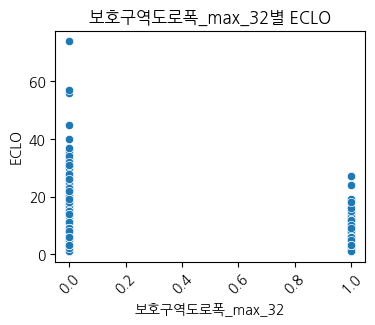

 95%|█████████▍| 53/56 [00:14<00:01,  2.61it/s]

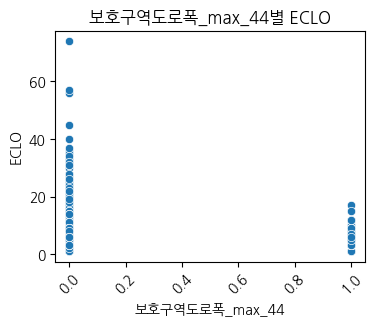

 96%|█████████▋| 54/56 [00:15<00:00,  2.54it/s]

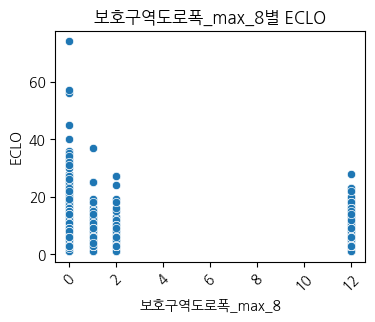

 98%|█████████▊| 55/56 [00:15<00:00,  2.59it/s]

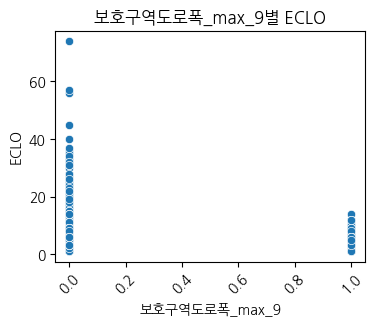

100%|██████████| 56/56 [00:15<00:00,  3.56it/s]


In [ ]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-56:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()


    # 필수 : 시설- 어린이집, 특수학교, 시설-학원, 경찰서명 - 강북, 남부, 중부, / 관리기관 - 대구광역시, 달성군청, 중구청, / cctv - 1대, 6, 7, 8, 9, 10, 11, 12, 14대 / 보호구역도로폭min 10, 3, 4, 43, 5, 6, 9, / 보호도로폭max 10, 11, 12, 13, 15, 17, 20, 25, 30, 32, 44, 8, 9,

In [ ]:
DG_children_area['시설종류'].value_counts()

유치원     267
초등학교    209
어린이집    155
특수학교      8
학원        1
Name: 시설종류, dtype: int64

In [ ]:
DG_children_area['관할경찰서명'].value_counts()

달성경찰서          198
수성경찰서          118
대구동부경찰서         85
강북경찰서           82
서부경찰서           56
남부경찰서           40
북부경찰서           40
대구광역시 중부경찰서     21
Name: 관할경찰서명, dtype: int64

In [ ]:
DG_children_area['관리기관명'].value_counts()

대구광역시 달성군청    198
대구광역시 북구청     122
대구광역시 수성구     118
대구광역시청         85
대구광역시 서구청      56
대구광역시          40
대구광역시 중구청      21
Name: 관리기관명, dtype: int64

In [ ]:
DG_children_area['CCTV설치대수'].value_counts()

0.0     187
1.0      76
2.0      73
4.0      45
3.0      32
5.0      22
6.0       8
8.0       6
7.0       4
12.0      4
9.0       3
14.0      2
11.0      2
10.0      1
Name: CCTV설치대수, dtype: int64

In [ ]:
DG_children_area['보호구역도로폭_min'].value_counts()

6     21
8      7
7      5
10     4
4      3
5      3
9      1
43     1
3      1
Name: 보호구역도로폭_min, dtype: int64

In [ ]:
DG_children_area['보호구역도로폭_max'].value_counts()

8     16
15     7
12     5
11     5
10     3
32     2
9      2
17     1
25     1
20     1
30     1
13     1
44     1
Name: 보호구역도로폭_max, dtype: int64

## 주차장

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_parking[['도시', '구', '동','번지']] = DG_parking['소재지지번주소'].str.extract(location_pattern)
DG_parking = DG_parking.drop(columns=['소재지지번주소'])

DG_parking

주차장관리번호           주차장명 주차장구분 주차장유형                    소재지도로명주소  \
0    153-2-000001        봉덕공영주차장    공영    노외        대구광역시 남구 중앙대로22길 199   
1    153-2-000002        봉삼공영주차장    공영    노외                         NaN   
2    153-2-000003      대명2동공영주차장    공영    노외         대구광역시 남구 중앙대로45길 57   
3    153-2-000004       고산골공영주차장    공영    노외            대구광역시 남구 용두2길 43   
4    153-2-000005      봉덕시장공영주차장    공영    노외           대구광역시 남구 봉덕로25길 6   
..            ...            ...   ...   ...                         ...   
866  150-4-000142       아세아유료주차장    민영    노외          대구광역시 중구 동덕로38길 14   
867  150-4-000143       코끼리유료주차장    민영    노외          대구광역시 중구 달성로22길 88   
868  150-4-000144       반월당유료주차장    민영    노외  대구광역시 중구 달구벌대로 2115-3(봉산동)   
869  150-4-000145        동덕유료주차장    민영    노외         대구광역시 중구 동덕로 114-11   
870  150-4-000146  계명대학교 동산병원주차장    민영    노외             대구광역시 중구 달성로 56   

     주차구획수  급지구분 부제시행구분        운영요일 평일운영시작시각  ...   월정기권요금 결제방법  \
0       62     1    미시행  평일+토요일+공휴일    08:00  ...  70000.0   현금   
1       36     1    미시행  평일+토요일+공휴일    08:00  ...  70000.0   현금   
2       31     1    미시행  평일+토요일+공휴일    08:00  ...  40000.0   현금   
3       88     2    미시행  평일+토요일+공휴일    08:00  ...  20000.0   현금   
4       32     1    미시행  평일+토요일+공휴일    00:00  ...  70000.0   현금   
..     ...   ...    ...         ...      ...  ...      ...  ...   
866     36     1    미시행      평일+토요일    06:50  ...      NaN   현금   
867     15     1    미시행      평일+토요일    08:00  ...      NaN   현금   
868     20     1    미시행      평일+토요일    07:00  ...      NaN   현금   
869     40     1    미시행      평일+토요일    08:00  ...      NaN   현금   
870    194     1    미시행      평일+토요일    08:00  ...      NaN   현금   

                                                  특기사항         위도          경도  \
0    경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.  35.842206  128.601725   
1    경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.  35.842811  128.597209   
2    경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.  35.855011  128.589359   
3    경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.  35.830066  128.603443   
4    경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.  35.844925  128.602667   
..                                                 ...        ...         ...   
866                                                NaN  35.871292  128.605331   
867                                         1시간 2,000원  35.874460  128.586939   
868                                                NaN  35.865434  128.595350   
869                                                NaN  35.864850  128.603883   
870                      의료원 방문목적 외 차량 추가요금 시간당 1,000원  35.870180  128.582521   

        데이터기준일자     도시   구      동       번지  
0    2020-01-01  대구광역시  남구    봉덕동  1002-69  
1    2020-01-01  대구광역시  남구    봉덕동    687-8  
2    2020-01-01  대구광역시  남구    대명동  1803-10  
3    2020-01-01  대구광역시  남구    봉덕동     1256  
4    2020-01-01  대구광역시  남구    봉덕동    976-5  
..          ...    ...  ..    ...      ...  
866  2019-06-21  대구광역시  중구  동인동1가    330-8  
867  2019-06-21  대구광역시  중구    수창동     95-1  
868  2019-06-21  대구광역시  중구    봉산동     38-2  
869  2019-06-21  대구광역시  중구  삼덕동2가      246  
870  2019-06-21  대구광역시  중구    동산동      194  

[871 rows x 32 columns]

In [ ]:
DG_parking.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '주차구획수', '급지구분',
       '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항', '위도',
       '경도', '데이터기준일자', '도시', '구', '동', '번지'],
      dtype='object')

In [ ]:
# for col in DG_parking.columns :
#     display(DG_parking[col].value_counts())

# 범주 - 주차장구분, 주차장유형, 급지구분, 부시행제 구분, 운영요일, 요금정보, 결제방법,
# 숫자 - 주차구획수, 평일운영시작시각, 공휴일운영종료시각, '추가단위시간','추가단위요금',주차기본시간, 주차기본요금

In [ ]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_parking[['도시','구','동']]

df1 = pd.get_dummies(DG_parking['주차장구분'], prefix = '주차장구분')
df2 = pd.get_dummies(DG_parking['주차장유형'], prefix = '주차장유형')
df3 = pd.get_dummies(DG_parking['급지구분'], prefix = '급지구분')
df4 = pd.get_dummies(DG_parking['부제시행구분'], prefix = '부제시행구분')
df5 = pd.get_dummies(DG_parking['운영요일'], prefix = '운영요일')
df6 = pd.get_dummies(DG_parking['요금정보'], prefix = '요금정보')
df7 = pd.get_dummies(DG_parking['결제방법'], prefix = '결제방법')


parking_merge= pd.concat([df, df1, df2, df3, df4, df5, df6, df7], axis=1)

parking_merge_df = parking_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(parking_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(parking_merge_df, on = ['도시','구','동'], how='left')


In [ ]:
train_df.columns[-23:]

Index(['주차장구분_공영', '주차장구분_민영', '주차장유형_노상', '주차장유형_노외', '급지구분_1', '급지구분_2',
       '급지구분_3', '부제시행구분_미시행', '운영요일_평일', '운영요일_평일+토요일', '운영요일_평일+토요일+공휴일',
       '요금정보_무료', '요금정보_유료', '요금정보_혼합', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드'],
      dtype='object')

In [ ]:
train_df.shape, test_df.shape

((39609, 136), (10963, 121))

  0%|          | 0/23 [00:00<?, ?it/s]

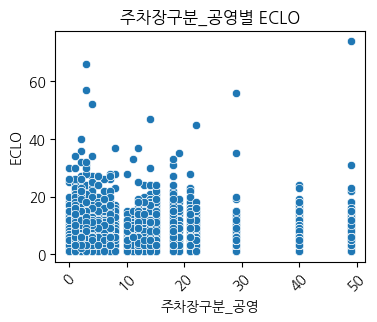

  4%|▍         | 1/23 [00:00<00:07,  2.80it/s]

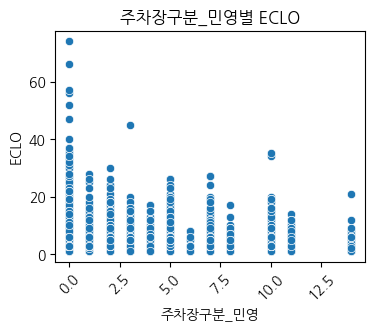

  9%|▊         | 2/23 [00:00<00:07,  2.70it/s]

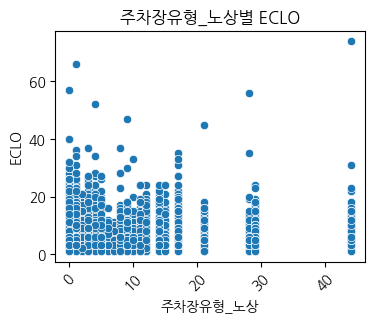

 13%|█▎        | 3/23 [00:01<00:07,  2.64it/s]

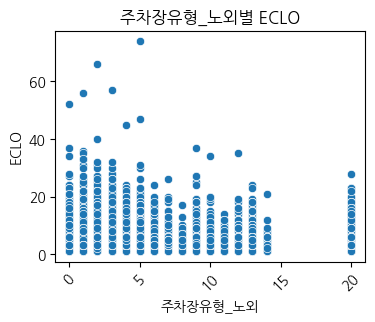

 17%|█▋        | 4/23 [00:01<00:06,  2.76it/s]

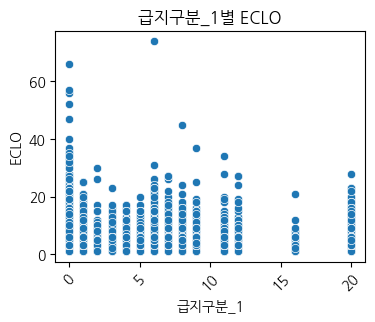

 22%|██▏       | 5/23 [00:01<00:07,  2.43it/s]

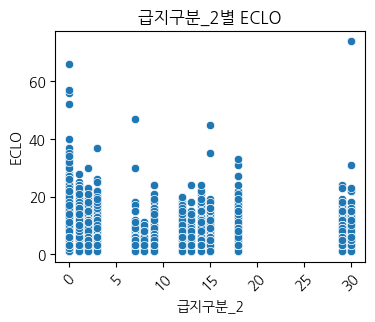

 26%|██▌       | 6/23 [00:02<00:06,  2.74it/s]

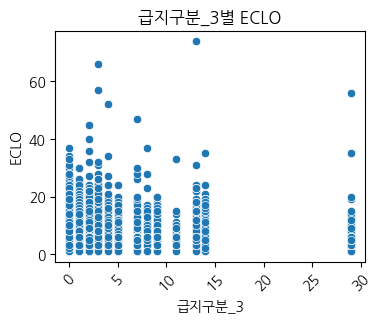

 30%|███       | 7/23 [00:02<00:05,  3.01it/s]

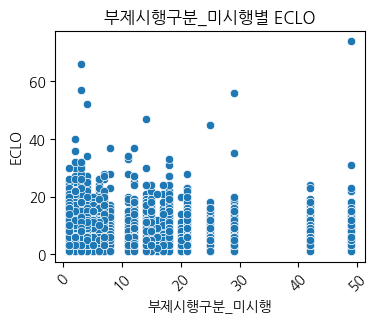

 35%|███▍      | 8/23 [00:02<00:04,  3.24it/s]

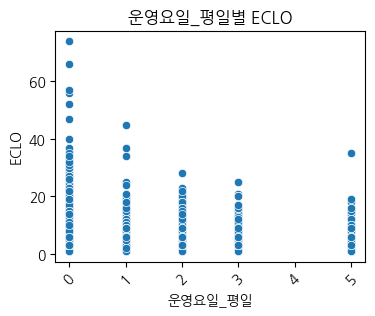

 39%|███▉      | 9/23 [00:03<00:04,  3.40it/s]

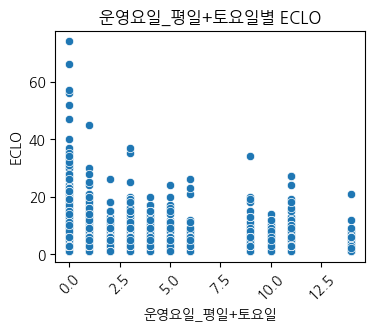

 43%|████▎     | 10/23 [00:03<00:03,  3.50it/s]

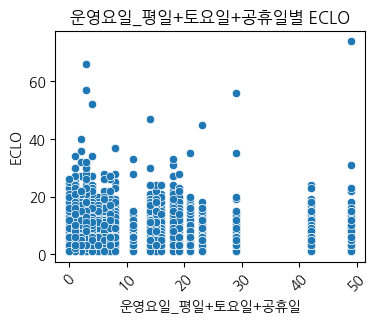

 48%|████▊     | 11/23 [00:03<00:03,  3.57it/s]

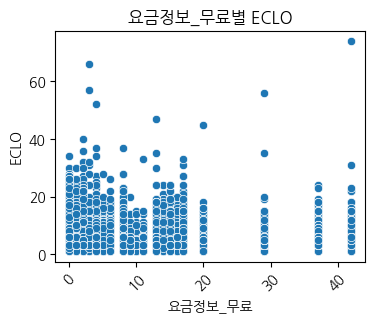

 52%|█████▏    | 12/23 [00:03<00:03,  3.66it/s]

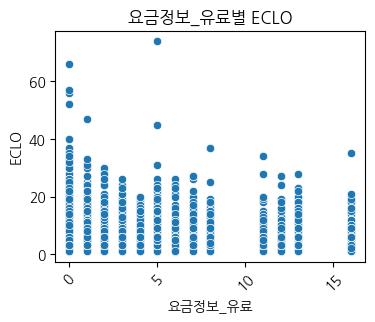

 57%|█████▋    | 13/23 [00:04<00:02,  3.76it/s]

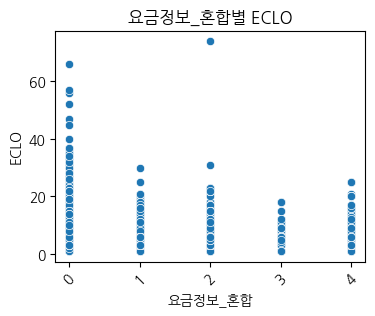

 61%|██████    | 14/23 [00:04<00:02,  3.75it/s]

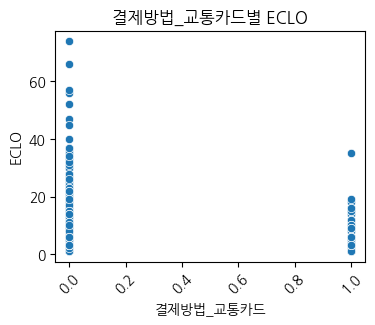

 65%|██████▌   | 15/23 [00:04<00:02,  3.72it/s]

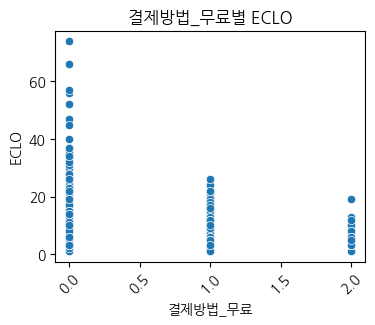

 70%|██████▉   | 16/23 [00:04<00:01,  3.73it/s]

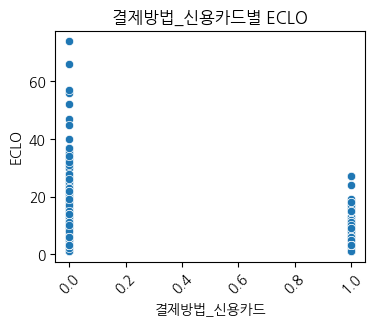

 74%|███████▍  | 17/23 [00:05<00:01,  3.72it/s]

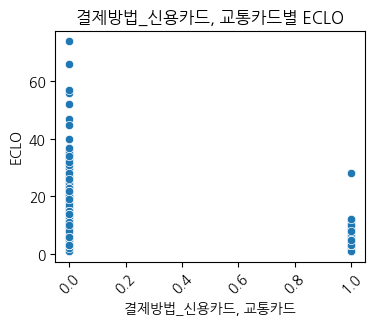

 78%|███████▊  | 18/23 [00:05<00:01,  3.77it/s]

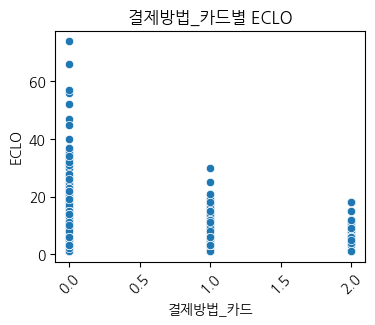

 83%|████████▎ | 19/23 [00:05<00:01,  3.83it/s]

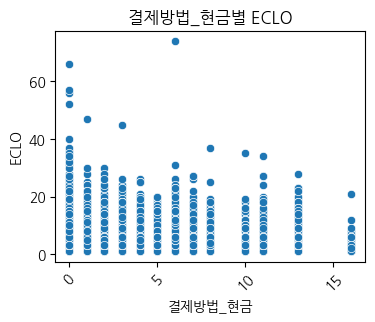

 87%|████████▋ | 20/23 [00:05<00:00,  3.89it/s]

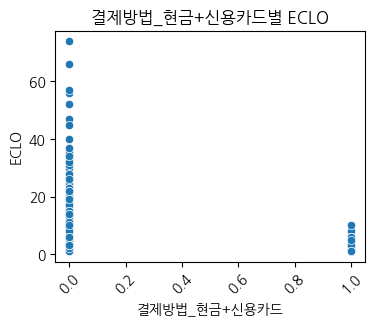

 91%|█████████▏| 21/23 [00:06<00:00,  3.89it/s]

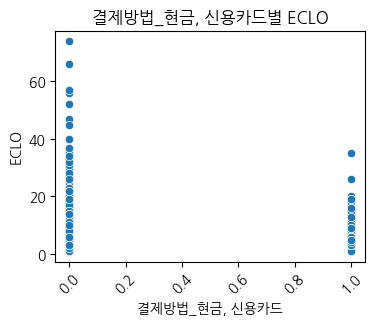

 96%|█████████▌| 22/23 [00:06<00:00,  3.90it/s]

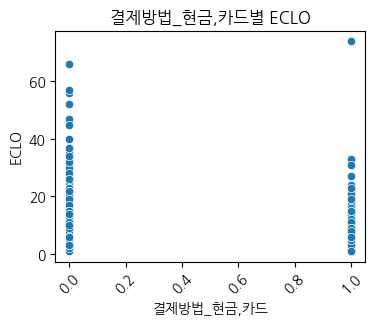

100%|██████████| 23/23 [00:06<00:00,  3.45it/s]


In [ ]:

from tqdm import tqdm

for col in tqdm(train_df.columns[-23:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

    # 필수 : 민영, 노외, 급지구분 1, 2, 3, 운영요일- 평일, 평일_토요일, 결제방법별 ***
    # 선택 : 급지구분 3,

In [ ]:
# 숫자 - 주차구획수, 평일운영시작시각, 공휴일운영종료시각, '추가단위시간','추가단위요금','주차기본시간', '주차기본요금'

DG_parking.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '주차구획수', '급지구분',
       '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항', '위도',
       '경도', '데이터기준일자', '도시', '구', '동', '번지'],
      dtype='object')

In [ ]:
parking_num_cols = ['도시','구','동','주차구획수', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '공휴일운영시작시각', '공휴일운영종료시각','주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금' ]

df = DG_parking[parking_num_cols]

from datetime import datetime

def time_to_int(time_str):
#     time_str = time
    time_obj = datetime.strptime(time_str, "%H:%M")
    # 시간을 분 단위로 변환하고 24로 나누어 표현
    hours_decimal = (time_obj.hour * 60 + time_obj.minute) / 60.0
    return hours_decimal

df['평일운영시작시각'] = df['평일운영시작시각'].apply(time_to_int)
df['평일운영종료시각'] = df['평일운영종료시각'].apply(time_to_int)
df['토요일운영시작시각'] = df['토요일운영시작시각'].apply(time_to_int)
df['토요일운영종료시각'] = df['토요일운영종료시각'].apply(time_to_int)
df['공휴일운영시작시각'] = df['공휴일운영시작시각'].apply(time_to_int)
df['공휴일운영종료시각'] = df['공휴일운영종료시각'].apply(time_to_int)


<ipython-input-69-9c934893fa71>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['평일운영시작시각'] = df['평일운영시작시각'].apply(time_to_int)
<ipython-input-69-9c934893fa71>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['평일운영종료시각'] = df['평일운영종료시각'].apply(time_to_int)
<ipython-input-69-9c934893fa71>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
df

도시   구      동  주차구획수  평일운영시작시각   평일운영종료시각  토요일운영시작시각  토요일운영종료시각  \
0    대구광역시  남구    봉덕동     62  8.000000  23.983333   8.000000  23.983333   
1    대구광역시  남구    봉덕동     36  8.000000  23.983333   8.000000  23.983333   
2    대구광역시  남구    대명동     31  8.000000  20.000000   8.000000  20.000000   
3    대구광역시  남구    봉덕동     88  8.000000  20.000000   8.000000  20.000000   
4    대구광역시  남구    봉덕동     32  0.000000  23.983333   0.000000  23.983333   
..     ...  ..    ...    ...       ...        ...        ...        ...   
866  대구광역시  중구  동인동1가     36  6.833333  18.500000   6.833333  18.500000   
867  대구광역시  중구    수창동     15  8.000000  18.000000   8.000000  18.000000   
868  대구광역시  중구    봉산동     20  7.000000  23.983333   7.000000  23.983333   
869  대구광역시  중구  삼덕동2가     40  8.000000  20.000000   8.000000  20.000000   
870  대구광역시  중구    동산동    194  8.000000  20.000000   8.000000  20.000000   

     공휴일운영시작시각  공휴일운영종료시각  주차기본시간  주차기본요금  추가단위시간  추가단위요금  1일주차권요금적용시간  \
0          8.0  23.983333      30     400    10.0   200.0        210.0   
1          8.0  23.983333      30     400    10.0   200.0        210.0   
2          8.0  20.000000      30     400    10.0   200.0        210.0   
3          8.0  20.000000      30     200    10.0   100.0        210.0   
4          0.0  23.983333      30     300    10.0   200.0        160.0   
..         ...        ...     ...     ...     ...     ...          ...   
866        0.0   0.000000      30    1000    15.0   500.0          NaN   
867        0.0   0.000000      30    1000     NaN     NaN          NaN   
868        0.0   0.000000      30    1000    30.0  1000.0          NaN   
869        0.0   0.000000      60    2000    60.0  1000.0          NaN   
870        0.0   0.000000      30     800    10.0   300.0          NaN   

     1일주차권요금   월정기권요금  
0     4000.0  70000.0  
1     4000.0  70000.0  
2     4000.0  40000.0  
3     2000.0  20000.0  
4     3000.0  70000.0  
..       ...      ...  
866      NaN      NaN  
867      NaN      NaN  
868      NaN      NaN  
869      NaN      NaN  
870      NaN      NaN  

[871 rows x 17 columns]

In [ ]:
parking_num_merge_df = df.groupby(['도시','구','동']).mean().reset_index()

train_df = train_df.merge(parking_num_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(parking_num_merge_df, on = ['도시','구','동'], how='left')

In [ ]:
parking_num_merge_df

도시    구      동      주차구획수  평일운영시작시각   평일운영종료시각  토요일운영시작시각  토요일운영종료시각  \
0    대구광역시   남구    대명동  33.761905  2.904762  21.941270   2.142857  20.036508   
1    대구광역시   남구    봉덕동  43.916667  4.666667  22.323611   4.000000  20.656944   
2    대구광역시   남구    이천동  14.333333  0.000000  23.983333   0.000000  23.983333   
3    대구광역시  달서구    갈산동  60.500000  0.000000   0.000000   0.000000   0.000000   
4    대구광역시  달서구    감삼동  28.500000  4.500000  11.000000   4.500000  11.000000   
..     ...  ...    ...        ...       ...        ...        ...        ...   
131  대구광역시   중구  태평로2가  35.600000  8.000000  19.800000   6.400000  15.800000   
132  대구광역시   중구  태평로3가  10.000000  9.000000  18.000000   9.000000  18.000000   
133  대구광역시   중구    포정동  31.750000  8.375000  20.750000   8.375000  20.750000   
134  대구광역시   중구    향촌동  40.000000  9.000000  20.000000   9.000000  20.000000   
135  대구광역시   중구    화전동  11.000000  9.000000  20.000000   9.000000  20.000000   

     공휴일운영시작시각  공휴일운영종료시각       주차기본시간       주차기본요금  추가단위시간       추가단위요금  \
0     2.142857  20.036508    18.571429   204.761905    10.0   207.692308   
1     2.000000  15.656944    20.000000   283.333333    10.0   225.000000   
2     0.000000  23.983333     0.000000     0.000000     NaN          NaN   
3     0.000000   0.000000  1440.000000     0.000000     NaN          NaN   
4     4.500000  11.000000   735.000000   150.000000    10.0   200.000000   
..         ...        ...          ...          ...     ...          ...   
131   0.000000   0.000000    36.000000  1000.000000    28.0   700.000000   
132   0.000000   0.000000    60.000000  1000.000000    30.0   500.000000   
133   0.000000   0.000000    37.500000  1000.000000    37.5  1000.000000   
134   0.000000   0.000000    45.000000  1000.000000    45.0  1000.000000   
135   9.000000  20.000000    60.000000  1000.000000    60.0  1000.000000   

     1일주차권요금적용시간       1일주차권요금         월정기권요금  
0         185.00   3545.454545   57272.727273  
1         203.75   4250.000000   63750.000000  
2            NaN           NaN            NaN  
3            NaN           NaN            NaN  
4            NaN           NaN   80000.000000  
..           ...           ...            ...  
131         4.00  10000.000000  100000.000000  
132          NaN           NaN            NaN  
133          NaN  50000.000000            NaN  
134          NaN           NaN            NaN  
135        10.00  10000.000000            NaN  

[136 rows x 17 columns]

In [ ]:
train_df.shape, test_df.shape

((39609, 150), (10963, 135))

In [ ]:
train_df.columns[-14:]

Index(['주차구획수', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '공휴일운영시작시각',
       '공휴일운영종료시각', '주차기본시간', '주차기본요금', '추가단위시간', '추가단위요금', '1일주차권요금적용시간',
       '1일주차권요금', '월정기권요금'],
      dtype='object')

  0%|          | 0/14 [00:00<?, ?it/s]

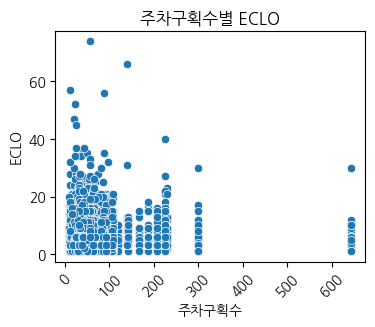

  7%|▋         | 1/14 [00:00<00:03,  3.93it/s]

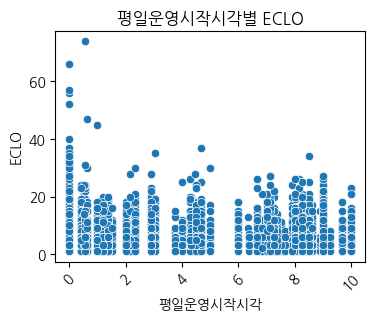

 14%|█▍        | 2/14 [00:00<00:03,  3.93it/s]

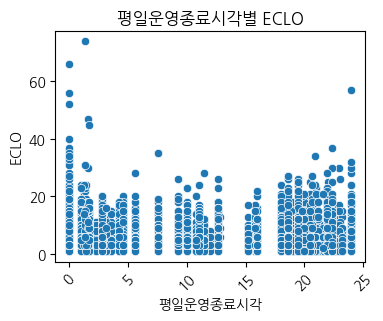

 21%|██▏       | 3/14 [00:00<00:02,  3.87it/s]

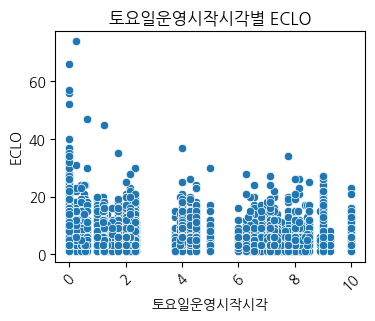

 29%|██▊       | 4/14 [00:01<00:02,  3.88it/s]

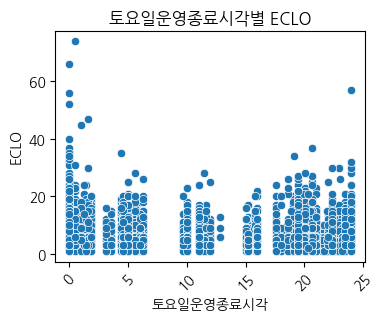

 36%|███▌      | 5/14 [00:01<00:02,  3.79it/s]

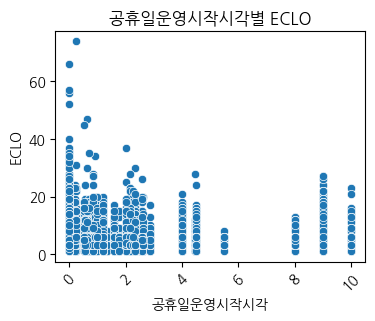

 43%|████▎     | 6/14 [00:01<00:02,  3.83it/s]

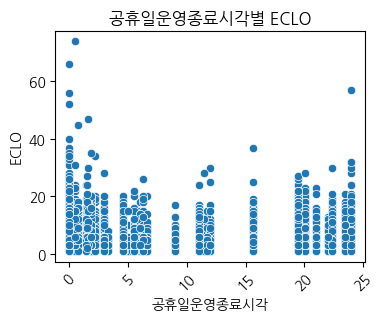

 50%|█████     | 7/14 [00:01<00:01,  3.81it/s]

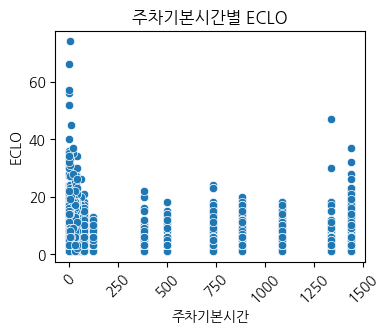

 57%|█████▋    | 8/14 [00:02<00:01,  3.81it/s]

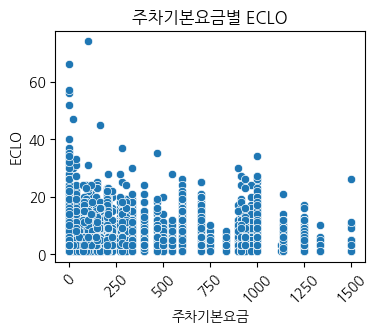

 64%|██████▍   | 9/14 [00:02<00:01,  3.83it/s]

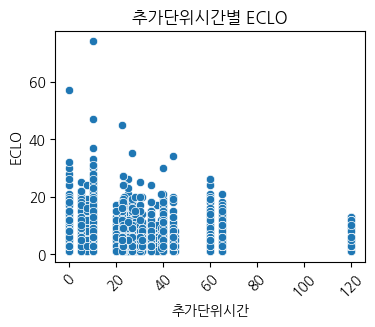

 71%|███████▏  | 10/14 [00:02<00:01,  3.91it/s]

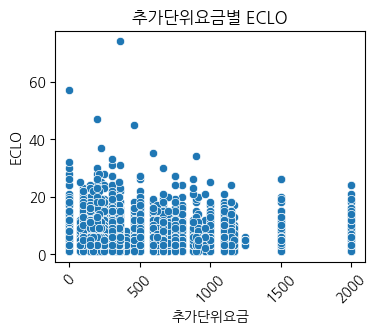

 79%|███████▊  | 11/14 [00:03<00:00,  3.09it/s]

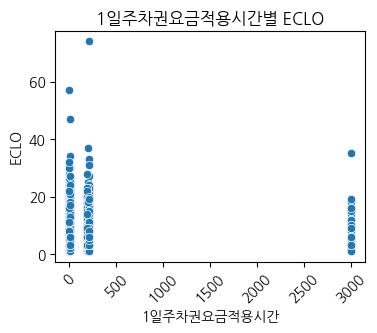

 86%|████████▌ | 12/14 [00:03<00:00,  3.37it/s]

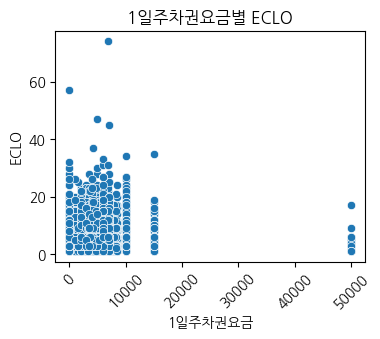

 93%|█████████▎| 13/14 [00:03<00:00,  3.55it/s]

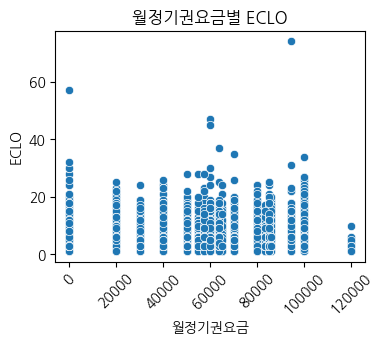

100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


In [ ]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-14:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()


# 주차구획수별, 토요일 운영 시작시간별, 추가단위시간별, 1일 주차권 요금 적용시간별, 1일 주차권 요금별,

In [ ]:
train_df.shape, test_df.shape

((39609, 150), (10963, 135))

In [ ]:
train_df.to_csv('train_df_150_1125.csv', index=False)

In [ ]:
test_df.to_csv('test_df_150_1125.csv', index=False)

# 모든 테스트 칼럼 확인

  0%|          | 0/134 [00:00<?, ?it/s]

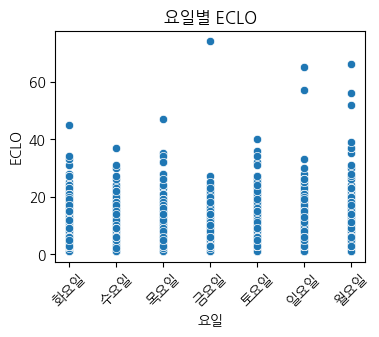

  1%|          | 1/134 [00:00<00:53,  2.50it/s]

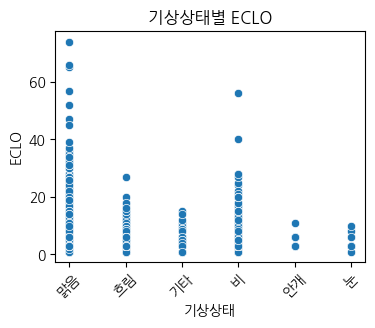

  1%|▏         | 2/134 [00:01<01:37,  1.35it/s]

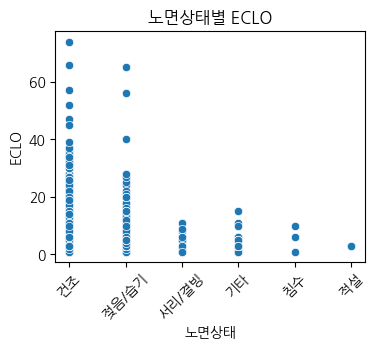

  2%|▏         | 3/134 [00:02<01:32,  1.41it/s]

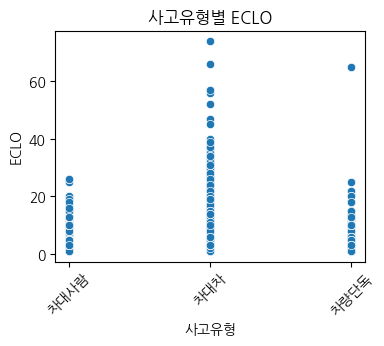

  3%|▎         | 4/134 [00:02<01:09,  1.87it/s]

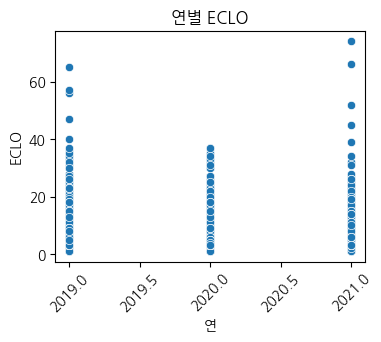

  4%|▎         | 5/134 [00:02<00:57,  2.23it/s]

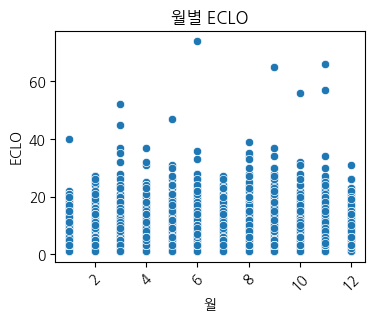

  4%|▍         | 6/134 [00:02<00:49,  2.60it/s]

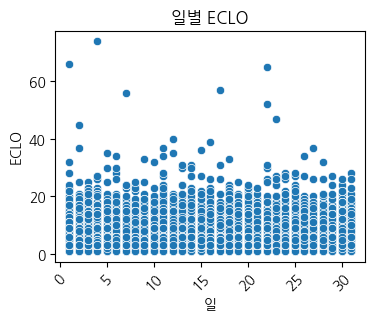

  5%|▌         | 7/134 [00:03<00:44,  2.87it/s]

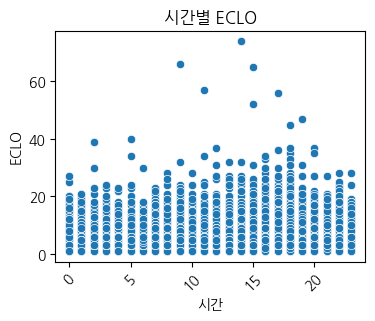

  6%|▌         | 8/134 [00:03<00:40,  3.13it/s]

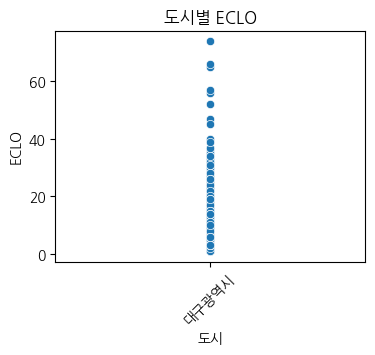

  7%|▋         | 9/134 [00:03<00:38,  3.27it/s]

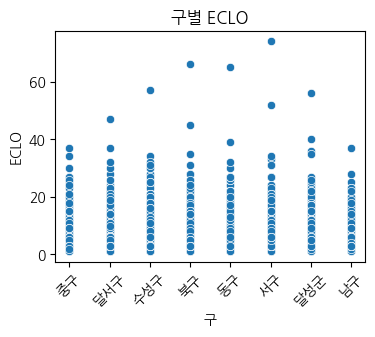

  7%|▋         | 10/134 [00:03<00:37,  3.28it/s]

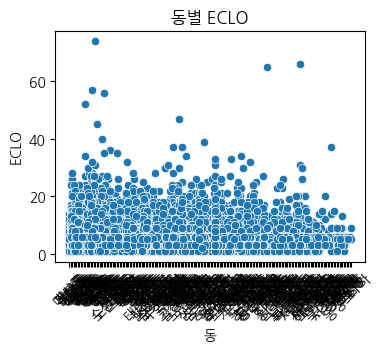

  8%|▊         | 11/134 [00:05<01:10,  1.76it/s]

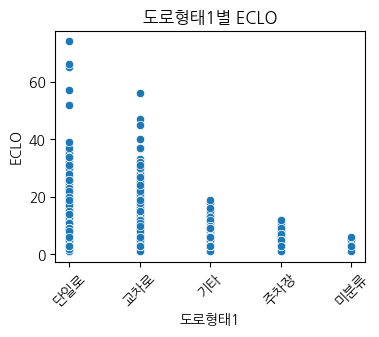

  9%|▉         | 12/134 [00:05<00:58,  2.07it/s]

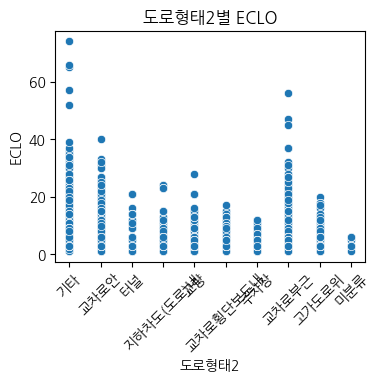

 10%|▉         | 13/134 [00:05<00:52,  2.31it/s]

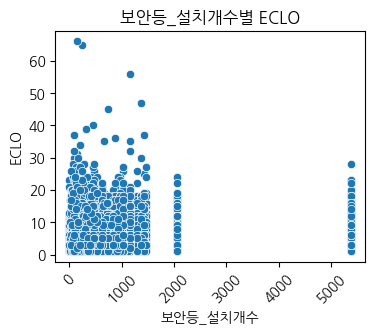

 10%|█         | 14/134 [00:06<00:46,  2.58it/s]

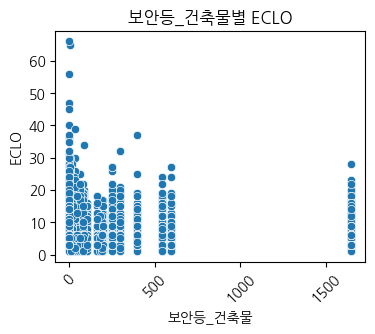

 11%|█         | 15/134 [00:06<00:41,  2.88it/s]

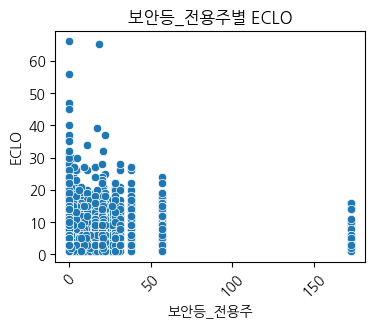

 12%|█▏        | 16/134 [00:06<00:38,  3.08it/s]

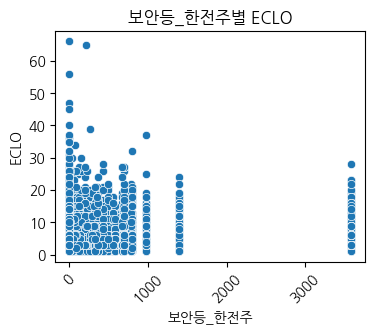

 13%|█▎        | 17/134 [00:06<00:36,  3.21it/s]

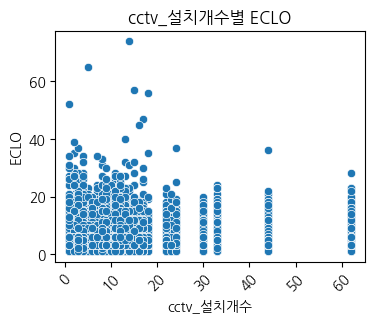

 13%|█▎        | 18/134 [00:07<00:34,  3.35it/s]

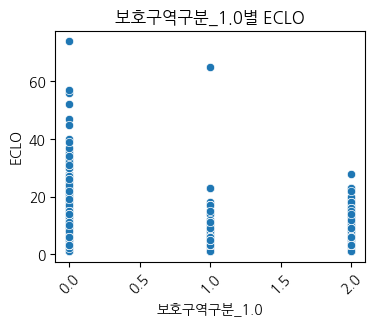

 14%|█▍        | 19/134 [00:07<00:33,  3.48it/s]

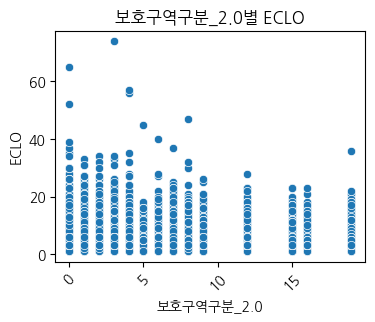

 15%|█▍        | 20/134 [00:07<00:31,  3.58it/s]

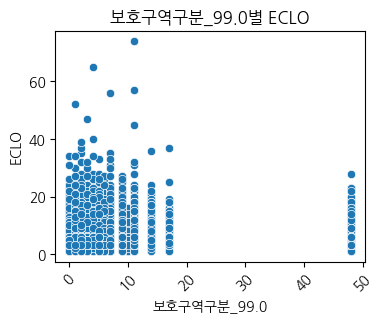

 16%|█▌        | 21/134 [00:07<00:31,  3.60it/s]

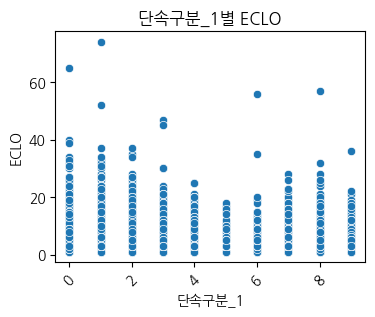

 16%|█▋        | 22/134 [00:08<00:38,  2.93it/s]

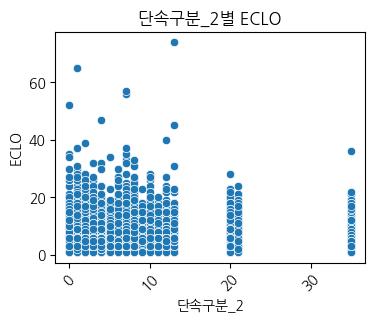

 17%|█▋        | 23/134 [00:08<00:35,  3.17it/s]

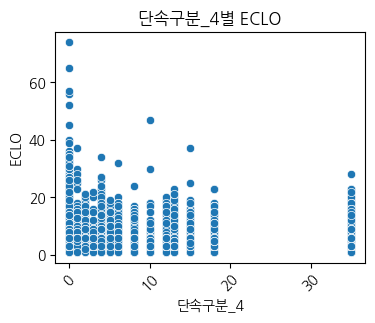

 18%|█▊        | 24/134 [00:08<00:33,  3.31it/s]

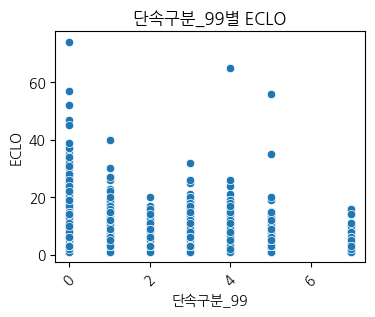

 19%|█▊        | 25/134 [00:09<00:31,  3.48it/s]

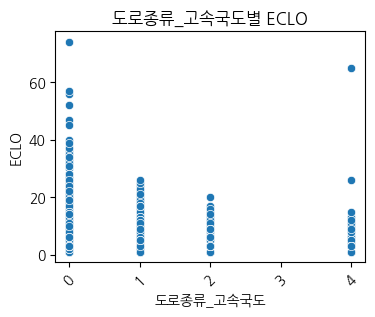

 19%|█▉        | 26/134 [00:09<00:29,  3.61it/s]

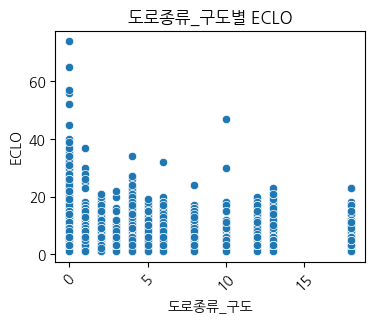

 20%|██        | 27/134 [00:09<00:29,  3.69it/s]

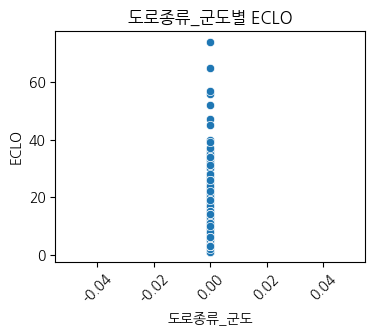

 21%|██        | 28/134 [00:09<00:29,  3.65it/s]

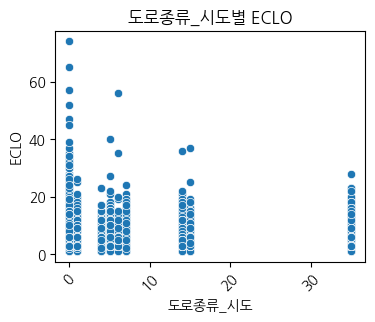

 22%|██▏       | 29/134 [00:10<00:28,  3.74it/s]

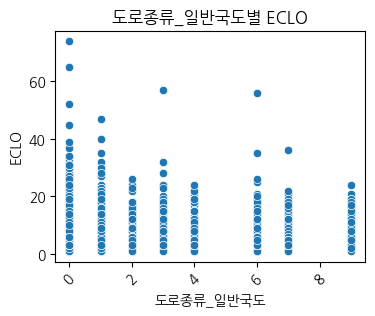

 22%|██▏       | 30/134 [00:10<00:27,  3.79it/s]

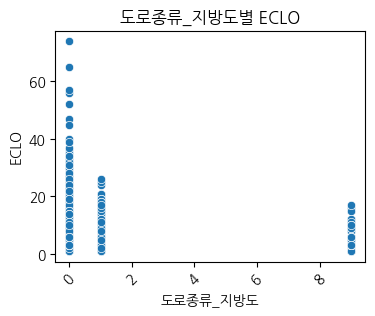

 23%|██▎       | 31/134 [00:10<00:27,  3.80it/s]

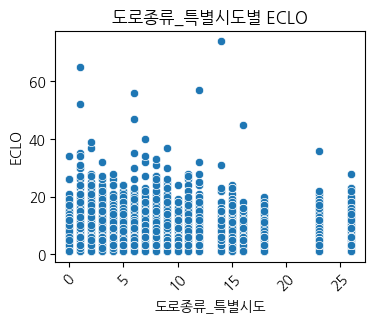

 24%|██▍       | 32/134 [00:11<00:27,  3.75it/s]

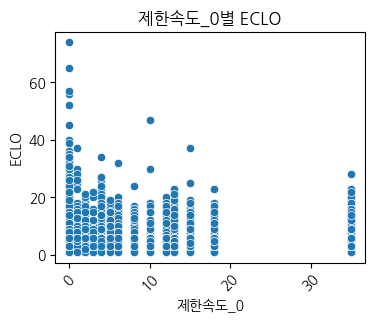

 25%|██▍       | 33/134 [00:11<00:27,  3.73it/s]

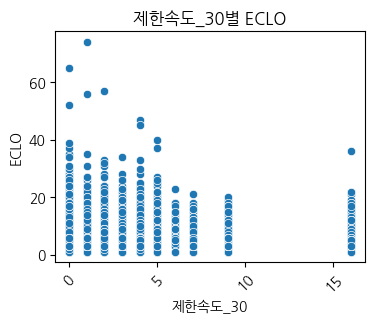

 25%|██▌       | 34/134 [00:11<00:26,  3.80it/s]

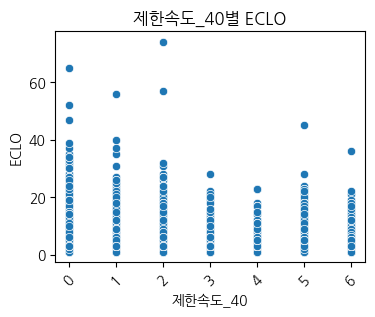

 26%|██▌       | 35/134 [00:11<00:26,  3.72it/s]

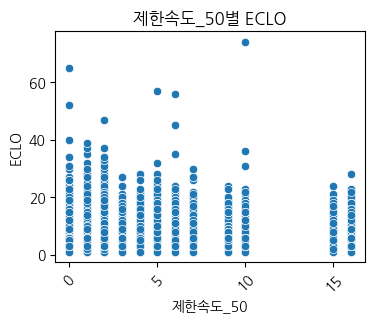

 27%|██▋       | 36/134 [00:12<00:25,  3.79it/s]

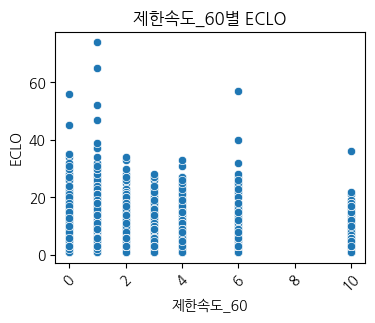

 28%|██▊       | 37/134 [00:12<00:28,  3.41it/s]

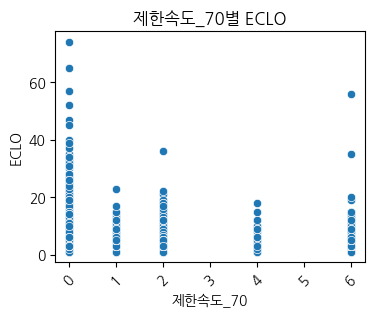

 28%|██▊       | 38/134 [00:12<00:31,  3.02it/s]

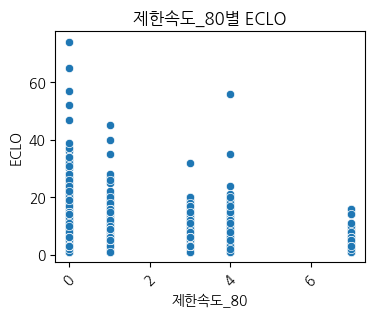

 29%|██▉       | 39/134 [00:13<00:32,  2.94it/s]

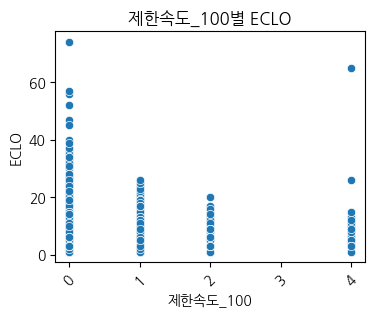

 30%|██▉       | 40/134 [00:13<00:33,  2.82it/s]

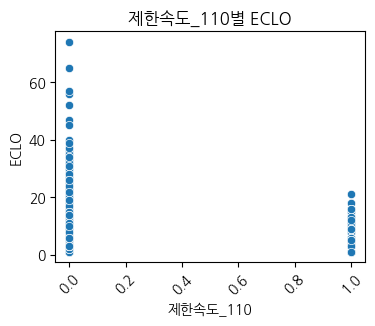

 31%|███       | 41/134 [00:13<00:33,  2.81it/s]

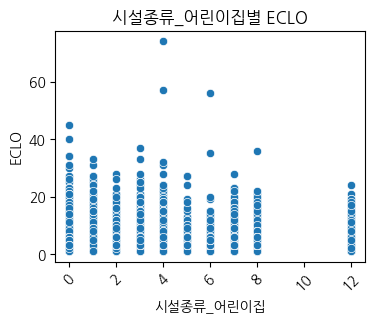

 31%|███▏      | 42/134 [00:14<00:31,  2.90it/s]

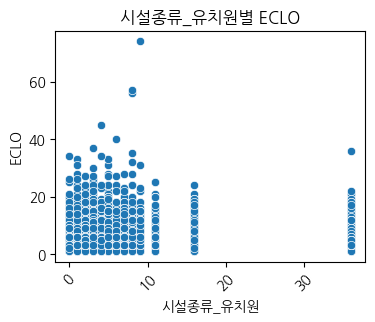

 32%|███▏      | 43/134 [00:14<00:31,  2.86it/s]

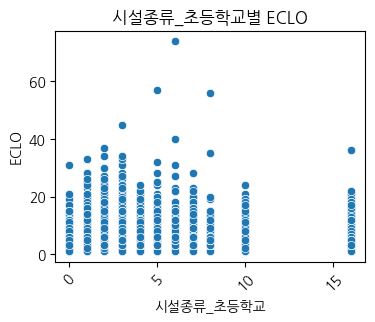

 33%|███▎      | 44/134 [00:14<00:31,  2.87it/s]

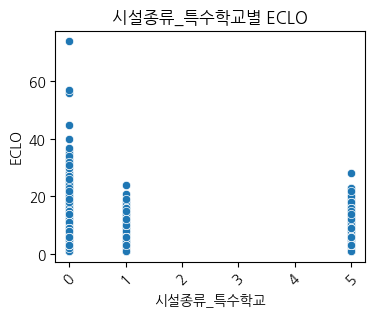

 34%|███▎      | 45/134 [00:15<00:31,  2.87it/s]

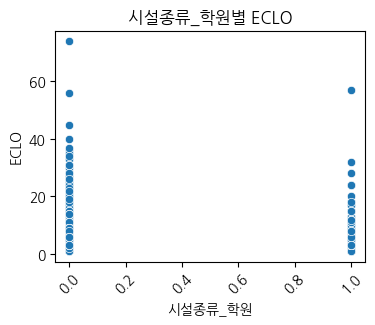

 34%|███▍      | 46/134 [00:15<00:30,  2.89it/s]

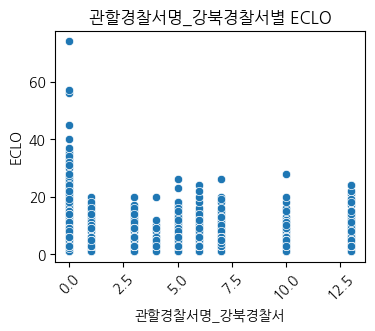

 35%|███▌      | 47/134 [00:16<00:29,  2.94it/s]

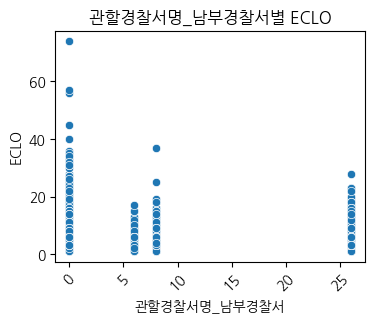

 36%|███▌      | 48/134 [00:16<00:28,  3.06it/s]

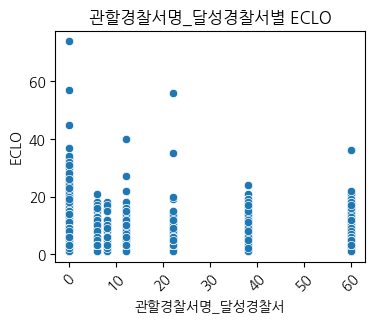

 37%|███▋      | 49/134 [00:16<00:28,  3.01it/s]

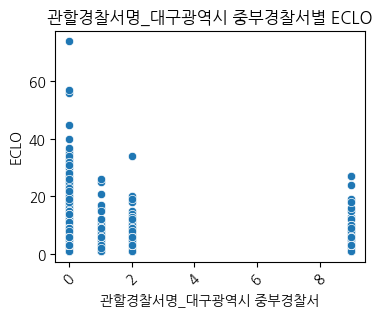

 37%|███▋      | 50/134 [00:17<00:28,  2.95it/s]

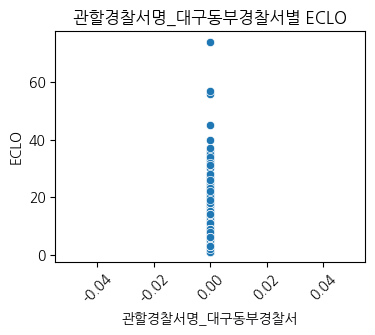

 38%|███▊      | 51/134 [00:17<00:27,  3.01it/s]

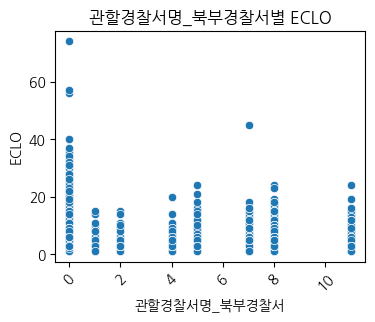

 39%|███▉      | 52/134 [00:17<00:28,  2.91it/s]

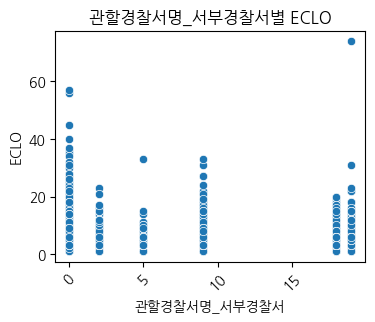

 40%|███▉      | 53/134 [00:17<00:27,  3.00it/s]

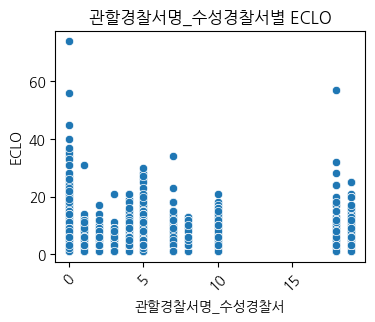

 40%|████      | 54/134 [00:18<00:26,  3.02it/s]

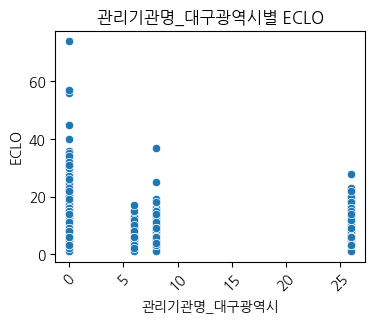

 41%|████      | 55/134 [00:18<00:26,  3.00it/s]

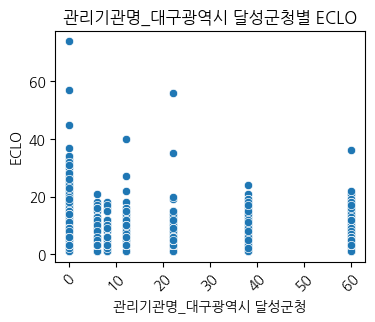

 42%|████▏     | 56/134 [00:19<00:34,  2.26it/s]

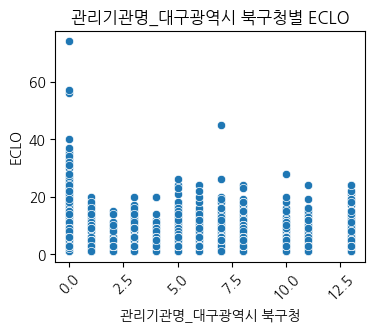

 43%|████▎     | 57/134 [00:19<00:31,  2.48it/s]

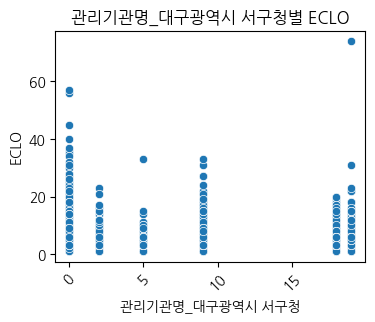

 43%|████▎     | 58/134 [00:19<00:27,  2.80it/s]

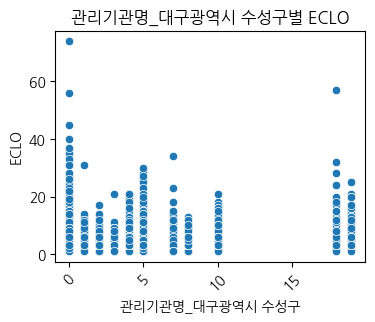

 44%|████▍     | 59/134 [00:20<00:24,  3.12it/s]

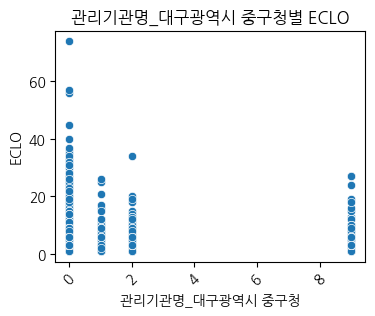

 45%|████▍     | 60/134 [00:20<00:22,  3.32it/s]

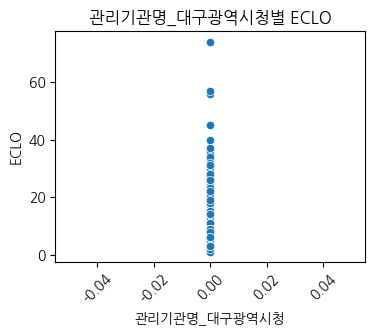

 46%|████▌     | 61/134 [00:20<00:20,  3.52it/s]

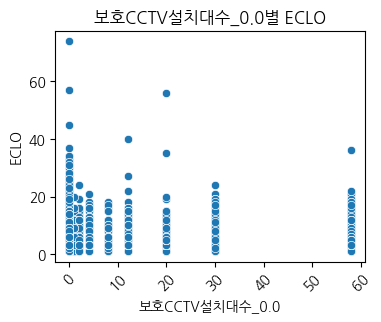

 46%|████▋     | 62/134 [00:20<00:19,  3.64it/s]

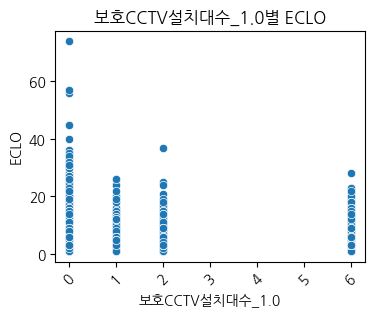

 47%|████▋     | 63/134 [00:21<00:18,  3.74it/s]

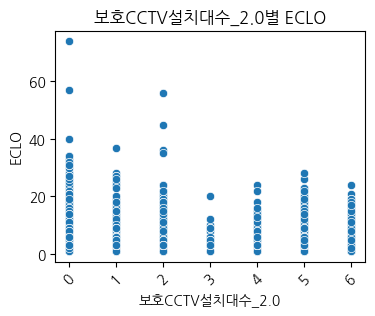

 48%|████▊     | 64/134 [00:21<00:18,  3.78it/s]

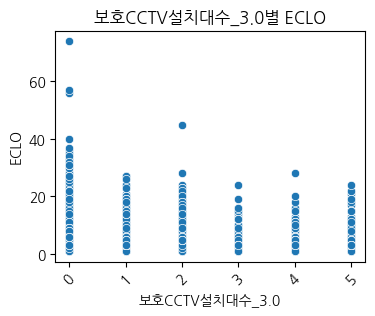

 49%|████▊     | 65/134 [00:21<00:17,  3.89it/s]

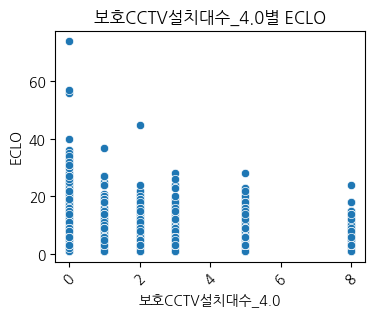

 49%|████▉     | 66/134 [00:21<00:17,  3.89it/s]

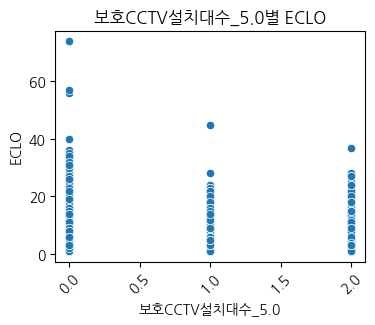

 50%|█████     | 67/134 [00:22<00:16,  3.97it/s]

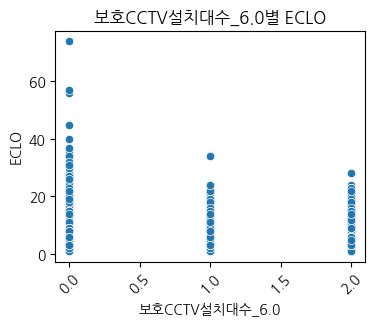

 51%|█████     | 68/134 [00:22<00:16,  3.98it/s]

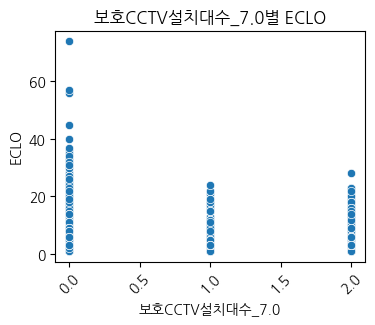

 51%|█████▏    | 69/134 [00:22<00:16,  4.03it/s]

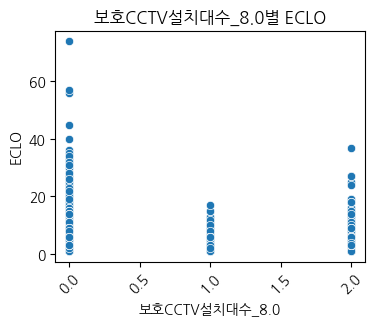

 52%|█████▏    | 70/134 [00:22<00:16,  3.84it/s]

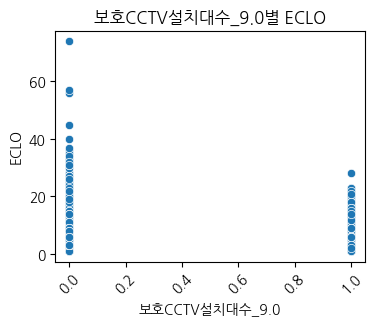

 53%|█████▎    | 71/134 [00:23<00:20,  3.06it/s]

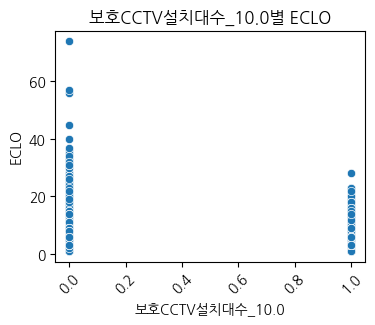

 54%|█████▎    | 72/134 [00:23<00:22,  2.73it/s]

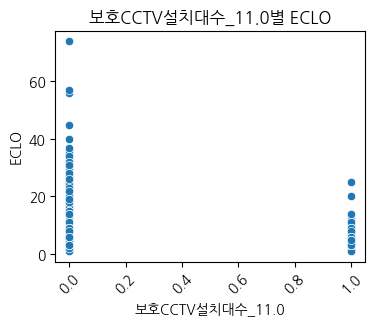

 54%|█████▍    | 73/134 [00:24<00:23,  2.65it/s]

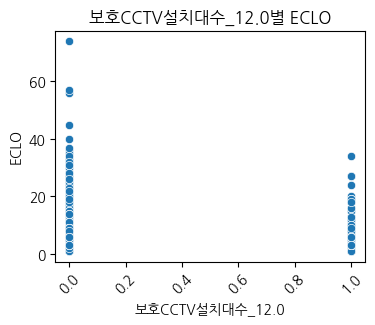

 55%|█████▌    | 74/134 [00:24<00:20,  2.92it/s]

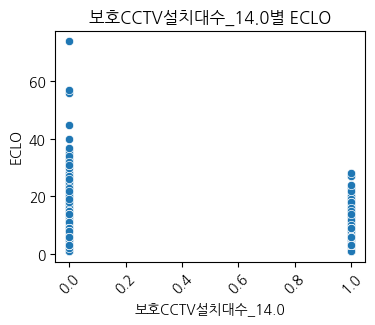

 56%|█████▌    | 75/134 [00:24<00:18,  3.15it/s]

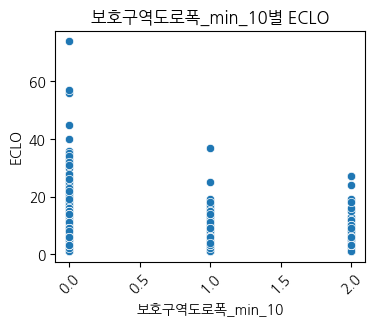

 57%|█████▋    | 76/134 [00:25<00:17,  3.36it/s]

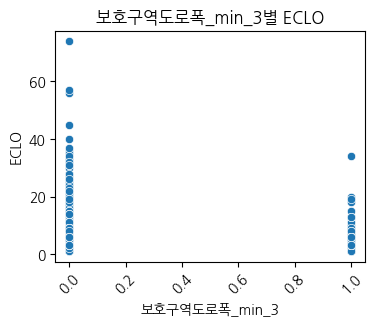

 57%|█████▋    | 77/134 [00:25<00:16,  3.51it/s]

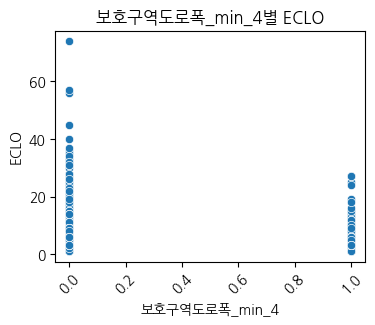

 58%|█████▊    | 78/134 [00:25<00:15,  3.65it/s]

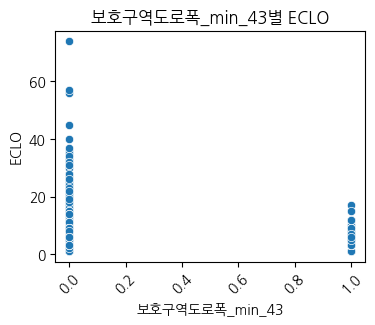

 59%|█████▉    | 79/134 [00:25<00:14,  3.73it/s]

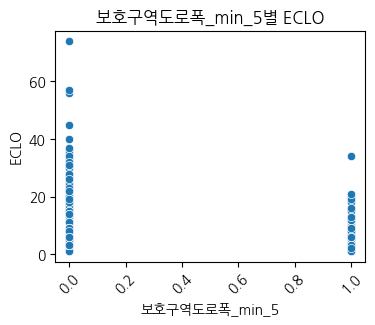

 60%|█████▉    | 80/134 [00:26<00:14,  3.80it/s]

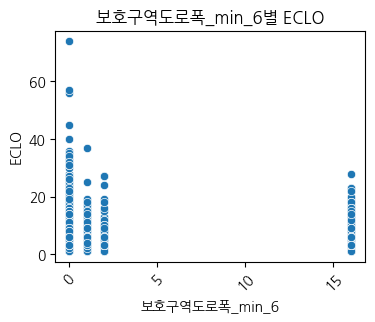

 60%|██████    | 81/134 [00:26<00:13,  3.92it/s]

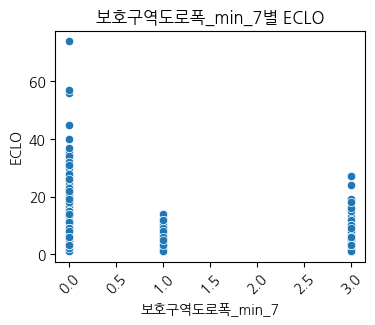

 61%|██████    | 82/134 [00:26<00:18,  2.89it/s]

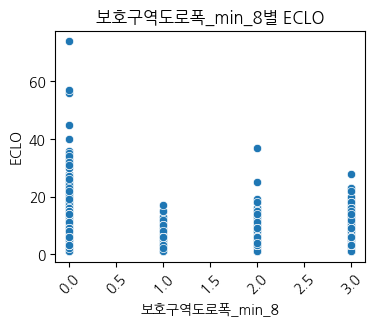

 62%|██████▏   | 83/134 [00:27<00:18,  2.82it/s]

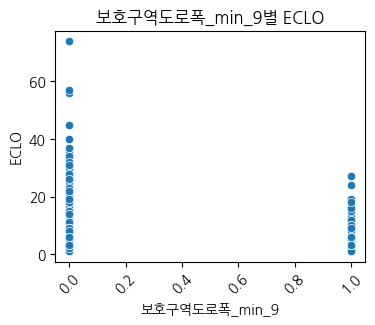

 63%|██████▎   | 84/134 [00:27<00:16,  3.09it/s]

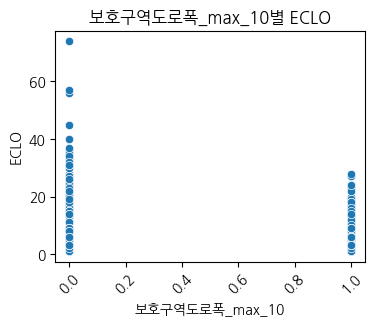

 63%|██████▎   | 85/134 [00:28<00:19,  2.54it/s]

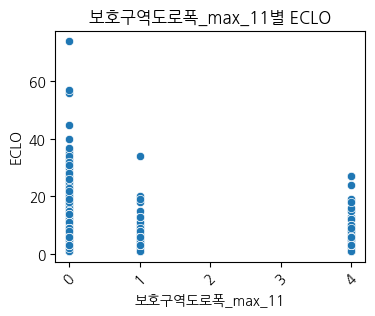

 64%|██████▍   | 86/134 [00:28<00:23,  2.01it/s]

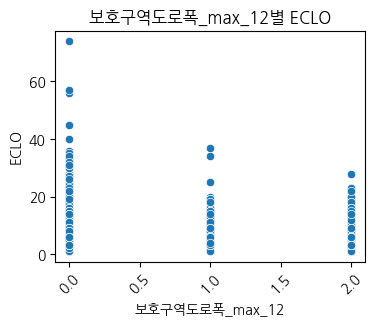

 65%|██████▍   | 87/134 [00:29<00:24,  1.89it/s]

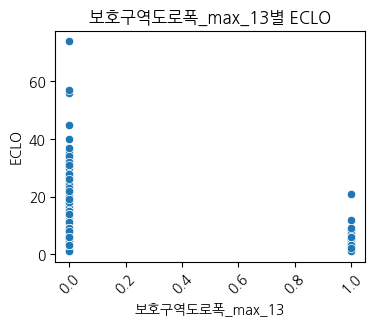

 66%|██████▌   | 88/134 [00:30<00:28,  1.63it/s]

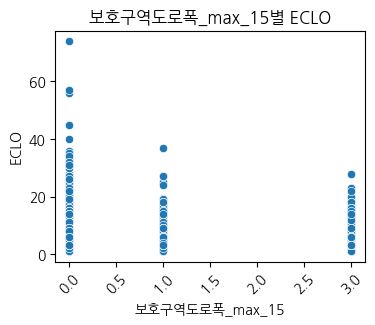

 66%|██████▋   | 89/134 [00:31<00:33,  1.36it/s]

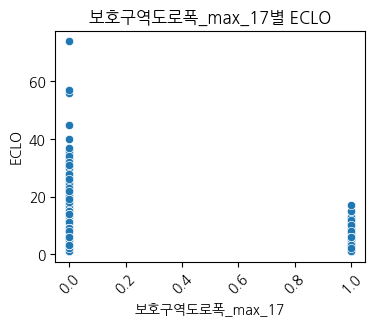

 67%|██████▋   | 90/134 [00:31<00:29,  1.47it/s]

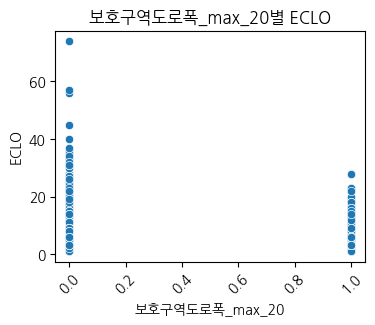

 68%|██████▊   | 91/134 [00:32<00:31,  1.35it/s]

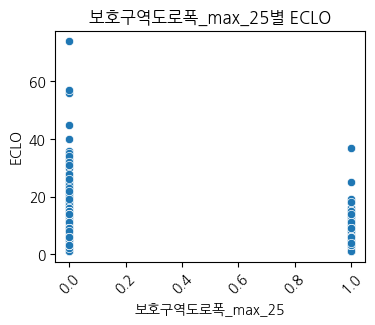

 69%|██████▊   | 92/134 [00:33<00:32,  1.28it/s]

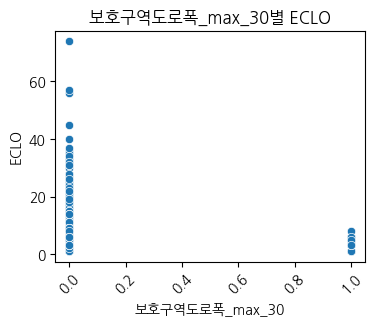

 69%|██████▉   | 93/134 [00:34<00:30,  1.34it/s]

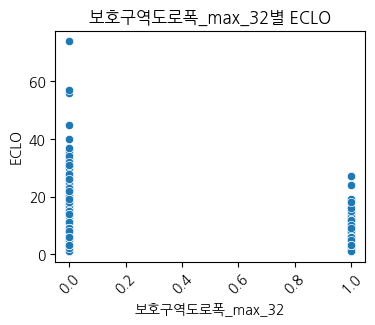

 70%|███████   | 94/134 [00:34<00:25,  1.54it/s]

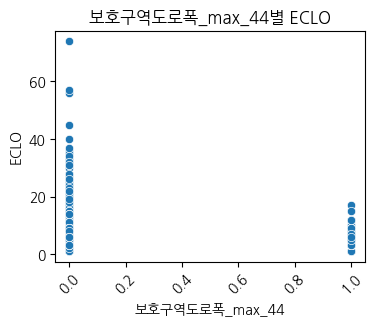

 71%|███████   | 95/134 [00:35<00:33,  1.18it/s]

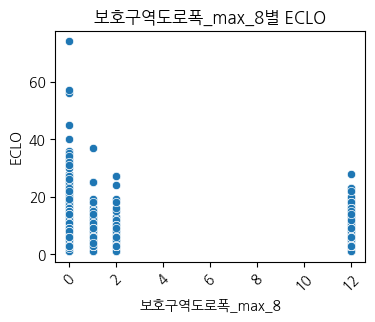

 72%|███████▏  | 96/134 [00:36<00:27,  1.37it/s]

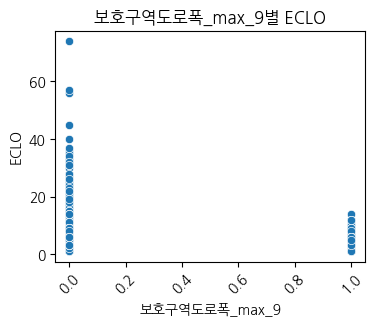

 72%|███████▏  | 97/134 [00:36<00:24,  1.53it/s]

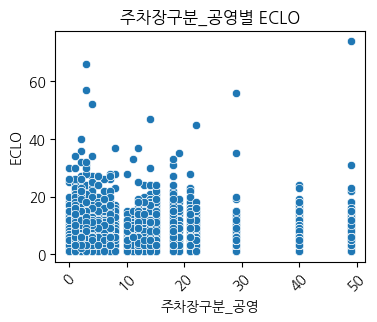

 73%|███████▎  | 98/134 [00:37<00:20,  1.72it/s]

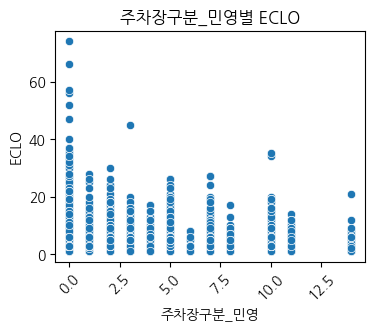

 74%|███████▍  | 99/134 [00:37<00:17,  2.05it/s]

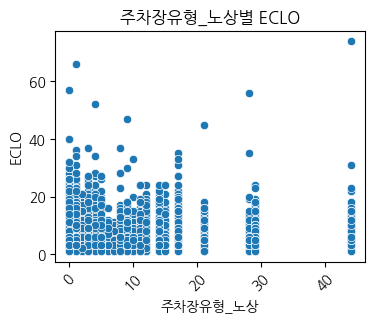

 75%|███████▍  | 100/134 [00:37<00:15,  2.22it/s]

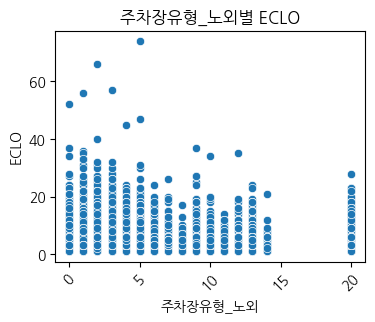

 75%|███████▌  | 101/134 [00:38<00:13,  2.45it/s]

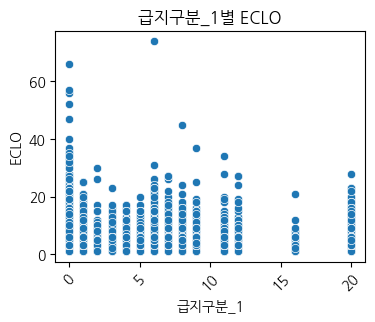

 76%|███████▌  | 102/134 [00:38<00:11,  2.70it/s]

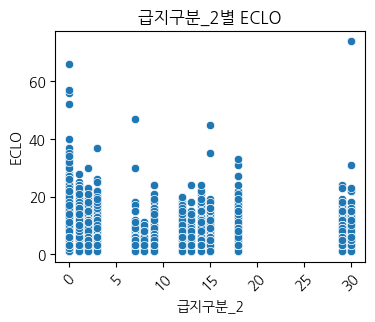

 77%|███████▋  | 103/134 [00:38<00:10,  2.83it/s]

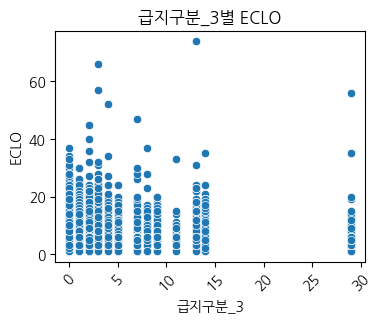

 78%|███████▊  | 104/134 [00:39<00:10,  2.90it/s]

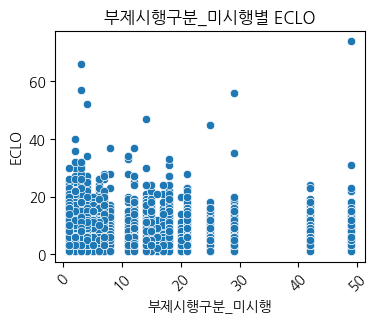

 78%|███████▊  | 105/134 [00:39<00:09,  3.00it/s]

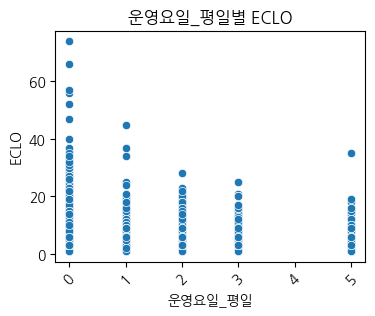

 79%|███████▉  | 106/134 [00:39<00:09,  3.09it/s]

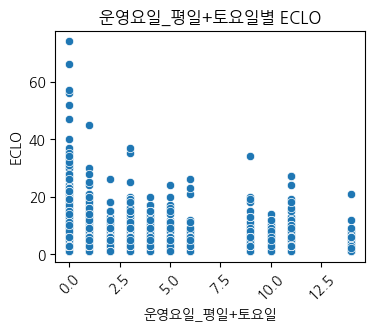

 80%|███████▉  | 107/134 [00:40<00:09,  2.99it/s]

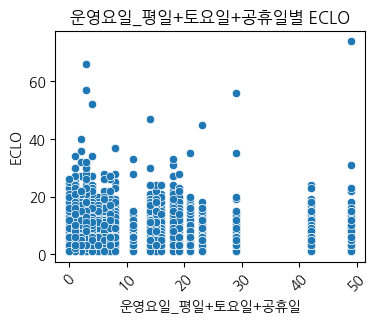

 81%|████████  | 108/134 [00:40<00:08,  3.07it/s]

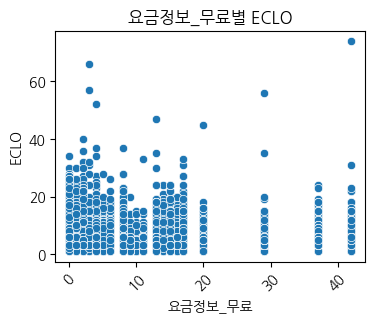

 81%|████████▏ | 109/134 [00:40<00:08,  2.96it/s]

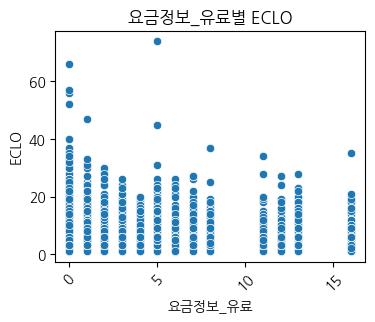

 82%|████████▏ | 110/134 [00:41<00:07,  3.12it/s]

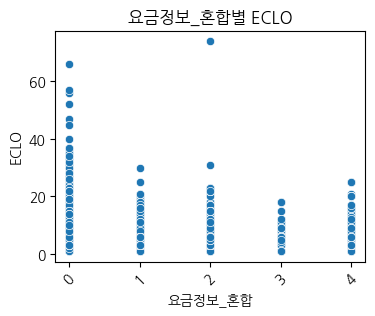

 83%|████████▎ | 111/134 [00:41<00:07,  3.25it/s]

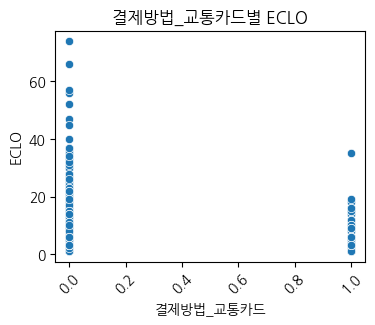

 84%|████████▎ | 112/134 [00:41<00:06,  3.23it/s]

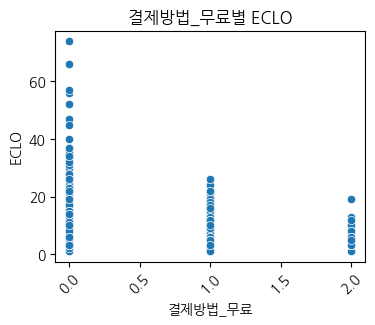

 84%|████████▍ | 113/134 [00:41<00:06,  3.12it/s]

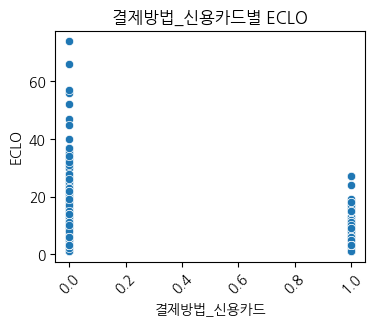

 85%|████████▌ | 114/134 [00:42<00:07,  2.52it/s]

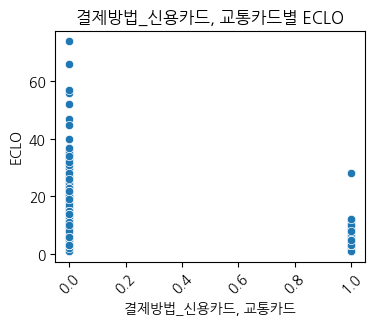

 86%|████████▌ | 115/134 [00:43<00:08,  2.30it/s]

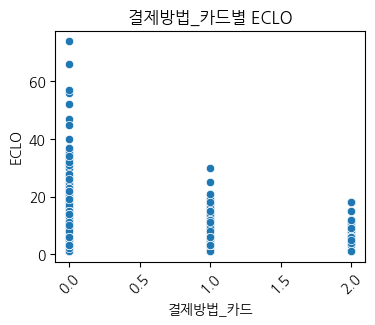

 87%|████████▋ | 116/134 [00:43<00:08,  2.07it/s]

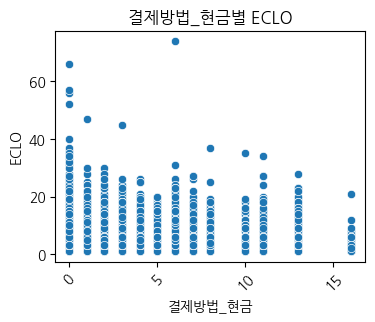

 87%|████████▋ | 117/134 [00:44<00:08,  2.02it/s]

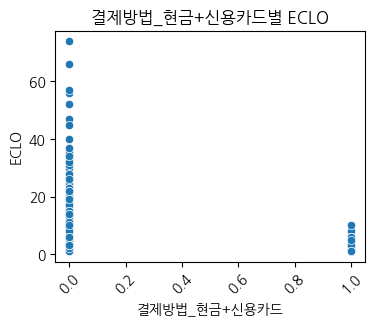

 88%|████████▊ | 118/134 [00:44<00:06,  2.32it/s]

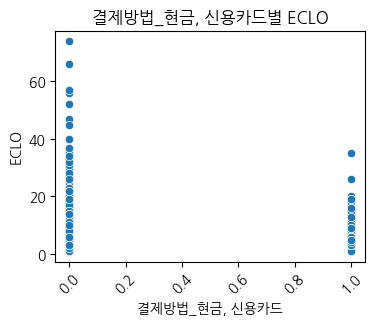

 89%|████████▉ | 119/134 [00:44<00:06,  2.19it/s]

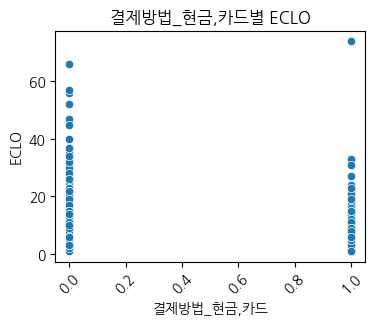

 90%|████████▉ | 120/134 [00:45<00:05,  2.47it/s]

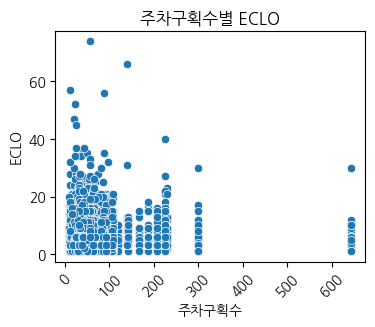

 90%|█████████ | 121/134 [00:45<00:05,  2.59it/s]

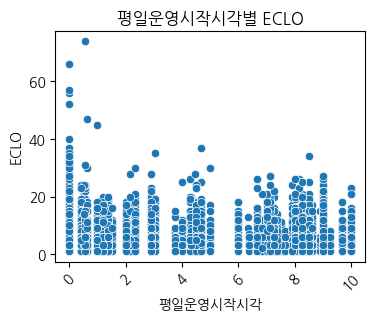

 91%|█████████ | 122/134 [00:45<00:04,  2.76it/s]

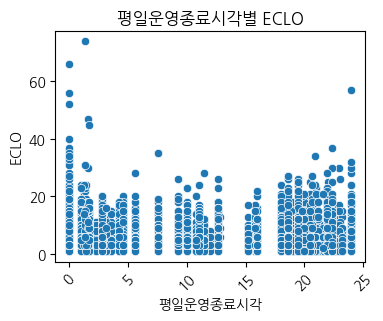

 92%|█████████▏| 123/134 [00:46<00:03,  2.86it/s]

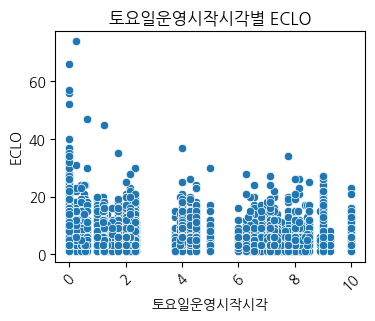

 93%|█████████▎| 124/134 [00:46<00:03,  2.61it/s]

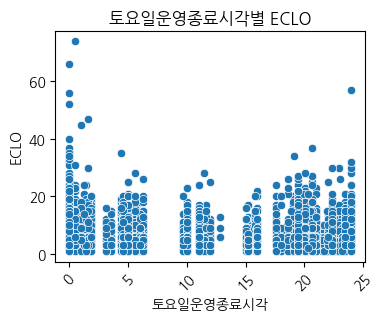

 93%|█████████▎| 125/134 [00:47<00:03,  2.37it/s]

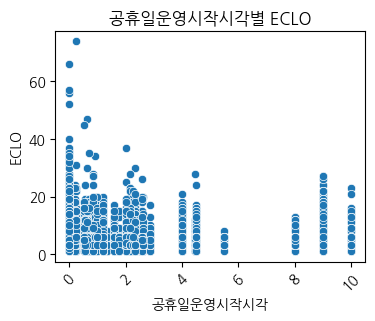

 94%|█████████▍| 126/134 [00:48<00:04,  1.82it/s]

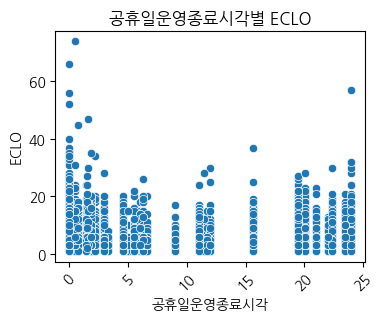

 95%|█████████▍| 127/134 [00:49<00:06,  1.12it/s]

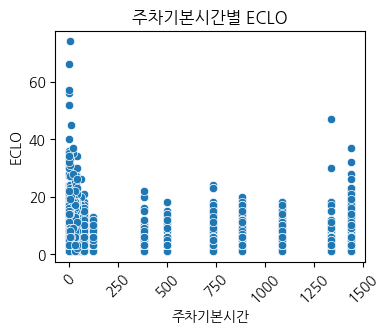

 96%|█████████▌| 128/134 [00:51<00:06,  1.01s/it]

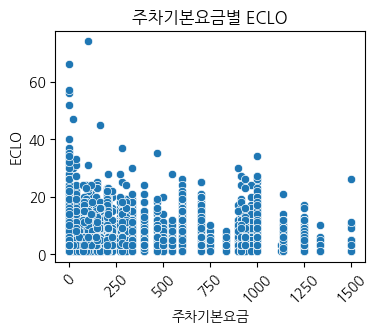

 96%|█████████▋| 129/134 [00:52<00:05,  1.12s/it]

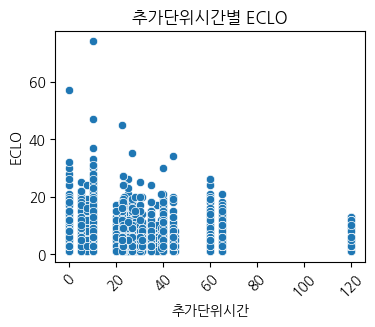

 97%|█████████▋| 130/134 [00:53<00:03,  1.02it/s]

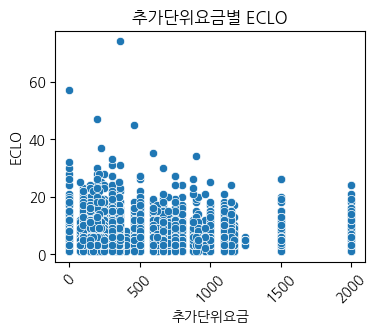

 98%|█████████▊| 131/134 [00:53<00:02,  1.26it/s]

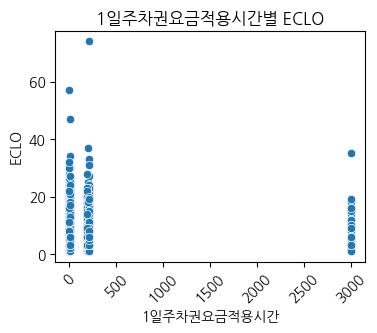

 99%|█████████▊| 132/134 [00:53<00:01,  1.51it/s]

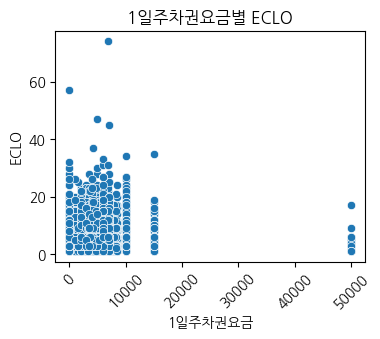

 99%|█████████▉| 133/134 [00:54<00:00,  1.75it/s]

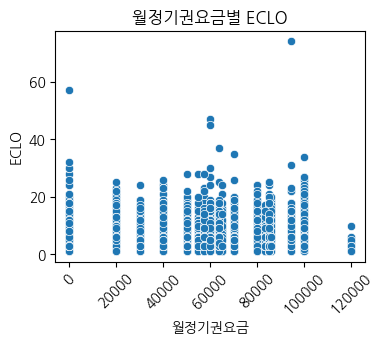

100%|██████████| 134/134 [00:54<00:00,  2.46it/s]


In [ ]:
from tqdm import tqdm

for col in tqdm(test_df.columns[1:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()
